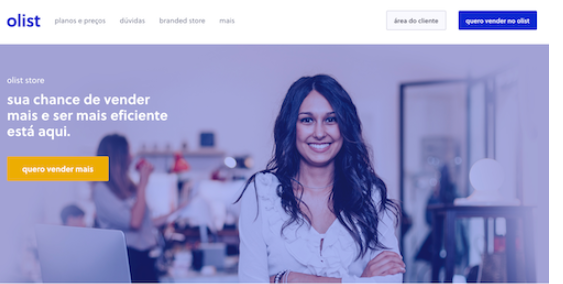

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import datetime as dt
from sklearn.cluster import KMeans
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('olist_dataset.csv')

In [3]:
df.head()

order_id    order_approved_at  temps_session  \
0  e481f51cbdc54678b7cc49136f2d6af7  2017-10-02 11:07:15          642.0   
1  e481f51cbdc54678b7cc49136f2d6af7  2017-10-02 11:07:15          642.0   
2  e481f51cbdc54678b7cc49136f2d6af7  2017-10-02 11:07:15          642.0   
3  53cdb2fc8bc7dce0b6741e2150273451  2018-07-26 03:24:27       110570.0   
4  47770eb9100c2d0c44946d9cf07ec65d  2018-08-08 08:55:23          994.0   

   experience_client  temps_livraison_estime  review_score  temps_de_reponse  \
0           728920.0               1342365.0           4.0          1.155417   
1           728920.0               1342365.0           4.0          1.155417   
2           728920.0               1342365.0           4.0          1.155417   
3          1190768.0               1542933.0           4.0          0.776273   
4           811660.0               2300677.0           5.0          4.797199   

   longueur_comment_message  payment_type  payment_value  ... audio  drinks  \
0                     170.0             1          18.12  ...     0       0   
1                     170.0             3           2.00  ...     0       0   
2                     170.0             3          18.59  ...     0       0   
3                      20.0             0         141.46  ...     0       0   
4                       1.0             1         179.12  ...     0       0   

   market_place  construction_tools_lights  \
0             0                          0   
1             0                          0   
2             0                          0   
3             0                          0   
4             0                          0   

   kitchen_dining_laundry_garden_furniture  air_conditioning food_drink  \
0                                        0                 0          0   
1                                        0                 0          0   
2                                        0                 0          0   
3                                        0                 0          0   
4                                        0                 0          0   

   fashion_shoes  industry_commerce_and_business  books_technical  
0              0                               0                0  
1              0                               0                0  
2              0                               0                0  
3              0                               0                0  
4              0                               0                0  

[5 rows x 57 columns]

# RFM (Recency, Frequency, Monetary)

* Récence (Recency) : Il s'agit du temps écoulé depuis la dernière transaction d'un client. Cette valeur mesure la fidélité du client et son activité récente.


* Fréquence (Frequency) : Il s'agit du nombre de transactions effectuées par un client au cours d'une période donnée. Cette valeur mesure la fidélité du client et son engagement.


* Montant (Monetary) : Il s'agit de la valeur totale des transactions effectuées par un client au cours d'une période donnée. Cette valeur mesure la valeur que le client représente pour l'entreprise.

In [4]:
# Make the date_placed column datetime
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

In [5]:
NOW = dt.datetime(2018, 12, 31)

In [6]:
rfm = df.groupby('customer_unique_id').agg({'order_approved_at': lambda x: (NOW - x.max()).days, # Recency
                                        'order_item_id': lambda x: len(x),      # Frequency
                                        'payment_value': lambda x: x.sum()}) # Monetary Value

In [7]:
rfm['order_approved_at'] = rfm['order_approved_at'].astype(int)

In [8]:
rfm.rename(columns={'order_approved_at': 'recency',
                    'order_item_id': 'frequency',
                    'payment_value': 'monetary_value'}, inplace=True)

## RFM Quartiles

In [9]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])

In [10]:
quantiles

recency  frequency  monetary_value
0.25    236.0        1.0          63.660
0.50    340.0        1.0         112.840
0.75    467.0        1.0         202.605

In [11]:
quantiles = quantiles.to_dict()

In [12]:
quantiles

{'recency': {0.25: 236.0, 0.5: 340.0, 0.75: 467.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary_value': {0.25: 63.66, 0.5: 112.84, 0.75: 202.60500000000002}}

## RFM Segmentation

In [13]:
rfmSegmentation = rfm.copy()

In [14]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [15]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [16]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [17]:
rfmSegmentation

recency  frequency  monetary_value  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2      234        1.0          141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f      237        1.0           27.19   
0000f46a3911fa3c0805444483337064      660        1.0           86.22   
0000f6ccb0745a6a4b88665a16c9f078      444        1.0           43.62   
0004aac84e0df4da2b147fca70cf8255      411        1.0          196.89   
...                                   ...        ...             ...   
fffcf5a5ff07b0908bd4e2dbc735a684      570        2.0         4134.84   
fffea47cd6d3cc0a88bd621562a9d061      385        1.0           84.58   
ffff371b4d645b6ecea244b27531430a      691        1.0          112.46   
ffff5962728ec6157033ef9805bacc48      242        1.0          133.69   
ffffd2657e2aad2907e67c3e9daecbeb      606        1.0           71.56   

                                  R_Quartile  F_Quartile  M_Quartile RFMClass  
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2           1           4           2      142  
0000b849f77a49e4a4ce2b2a4ca5be3f           2           4           4      244  
0000f46a3911fa3c0805444483337064           4           4           3      443  
0000f6ccb0745a6a4b88665a16c9f078           3           4           4      344  
0004aac84e0df4da2b147fca70cf8255           3           4           2      342  
...                                      ...         ...         ...      ...  
fffcf5a5ff07b0908bd4e2dbc735a684           4           1           1      411  
fffea47cd6d3cc0a88bd621562a9d061           3           4           3      343  
ffff371b4d645b6ecea244b27531430a           4           4           3      443  
ffff5962728ec6157033ef9805bacc48           2           4           2      242  
ffffd2657e2aad2907e67c3e9daecbeb           4           4           3      443  

[91074 rows x 7 columns]

In [18]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('monetary_value', ascending=False).head(5)

recency  frequency  monetary_value  \
customer_unique_id                                                     
adfa1cab2b2c8706db21bb13c0a1beb1      212        6.0        19457.04   
1b76903617af13189607a36b0469f6f3      221        6.0        19174.38   
fff5eb4918b2bf4b2da476788d42051c      178        6.0        17069.76   
be825ddd3b40db3f91bf05b4e9435d56      201        4.0        12490.88   
906a8a4ec9f3d4c3e64fa6d1c4fe6009      162        7.0        11881.01   

                                  R_Quartile  F_Quartile  M_Quartile RFMClass  
customer_unique_id                                                             
adfa1cab2b2c8706db21bb13c0a1beb1           1           1           1      111  
1b76903617af13189607a36b0469f6f3           1           1           1      111  
fff5eb4918b2bf4b2da476788d42051c           1           1           1      111  
be825ddd3b40db3f91bf05b4e9435d56           1           1           1      111  
906a8a4ec9f3d4c3e64fa6d1c4fe6009           1           1           1      111

Les clients ayant la meilleure récense, fréquence et valeur

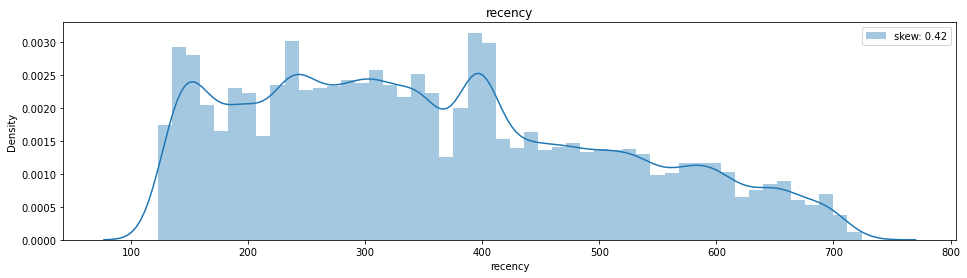

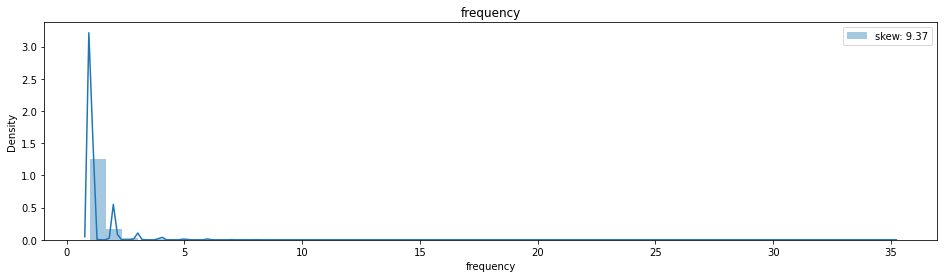

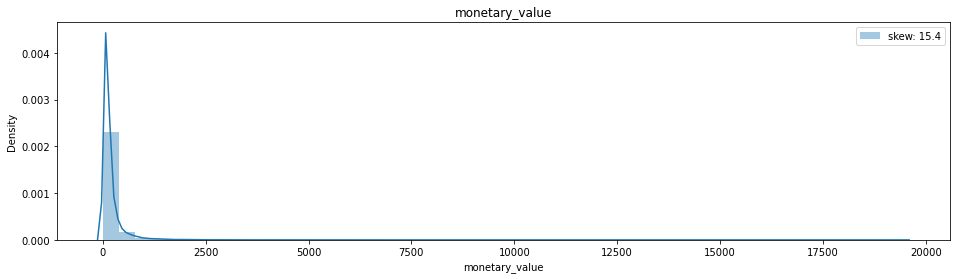

In [19]:
# réprésentation avec un displot 
for col in rfm:
    plt.figure(figsize=(16, 4))
    sns.distplot(rfm[col], label="skew: "+str(np.round(rfm[col].skew(),2)))
    plt.title(col)
    plt.legend()

In [20]:
import scipy.stats as st
import statsmodels.api as sm

In [21]:
for col in rfm:
        w, pvalue = st.shapiro(rfm[col])
        seuil = 0.05
        print(f'{col :-<50} {w} {pvalue}')
        if pvalue > seuil:
            print(
                "On ne peux pas rejetter H0: la distribution suit une loi normale")
        else:
            print(
                "On rejette H0 : la distribution ne suit pas une loi normale")

recency------------------------------------------- 0.9597442746162415 0.0
On rejette H0 : la distribution ne suit pas une loi normale
frequency----------------------------------------- 0.3187635540962219 0.0
On rejette H0 : la distribution ne suit pas une loi normale
monetary_value------------------------------------ 0.303963840007782 0.0
On rejette H0 : la distribution ne suit pas une loi normale


recency


<Figure size 432x288 with 0 Axes>

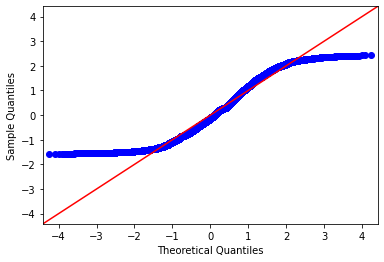

frequency


<Figure size 432x288 with 0 Axes>

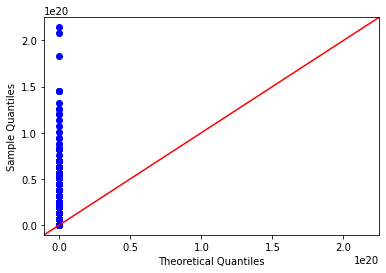

monetary_value


<Figure size 432x288 with 0 Axes>

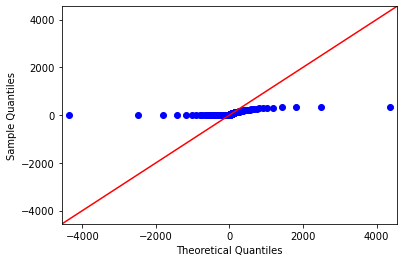

In [22]:
# qqpolot vs. loi normale (droite de Henry)
for col in rfm:
    plt.figure()
    sm.qqplot(rfm[col], st.t, fit=True, line="45")
    print(col)
    plt.show()

# Corrélation

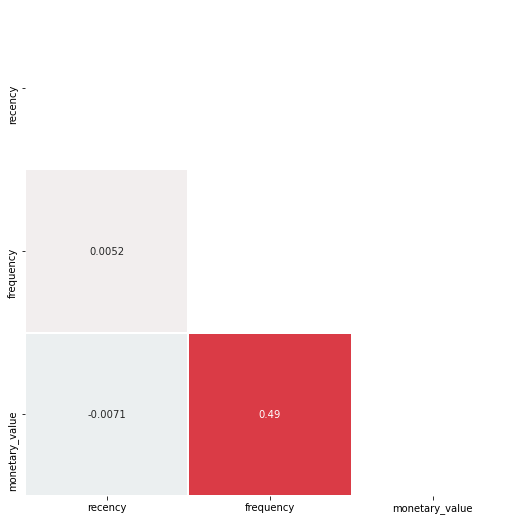

In [23]:
# Compute the correlation matrix
corr = rfm.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig = sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
                  square=True, linewidths=.5, cbar=None)

# Normalisation

In [24]:
rfm = rfm.reset_index()

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
rfm_transform = rfm.copy()

In [27]:
scaler = StandardScaler()

In [28]:
cols_to_scale = ['recency', 'frequency', 'monetary_value']

In [29]:
def scaleColumns(rfm_transform, cols_to_scale):
    for col in cols_to_scale:
        rfm_transform[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(rfm_transform[col])),columns=[col])
    return rfm_transform

In [30]:
rfm_scaled = scaleColumns(rfm_transform, cols_to_scale)
rfm_scaled

customer_unique_id   recency  frequency  monetary_value
0      0000366f3b9a7992bf8c76cfdf3221e2 -0.824816  -0.301230       -0.151566
1      0000b849f77a49e4a4ce2b2a4ca5be3f -0.804923  -0.301230       -0.411915
2      0000f46a3911fa3c0805444483337064  1.999912  -0.301230       -0.277939
3      0000f6ccb0745a6a4b88665a16c9f078  0.567656  -0.301230       -0.374625
4      0004aac84e0df4da2b147fca70cf8255  0.348839  -0.301230       -0.026759
...                                 ...       ...        ...             ...
91069  fffcf5a5ff07b0908bd4e2dbc735a684  1.403139   1.006343        8.910946
91070  fffea47cd6d3cc0a88bd621562a9d061  0.176438  -0.301230       -0.281661
91071  ffff371b4d645b6ecea244b27531430a  2.205467  -0.301230       -0.218384
91072  ffff5962728ec6157033ef9805bacc48 -0.771769  -0.301230       -0.170199
91073  ffffd2657e2aad2907e67c3e9daecbeb  1.641848  -0.301230       -0.311212

[91074 rows x 4 columns]

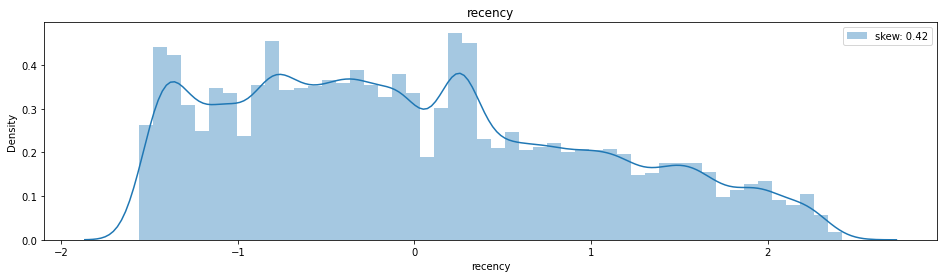

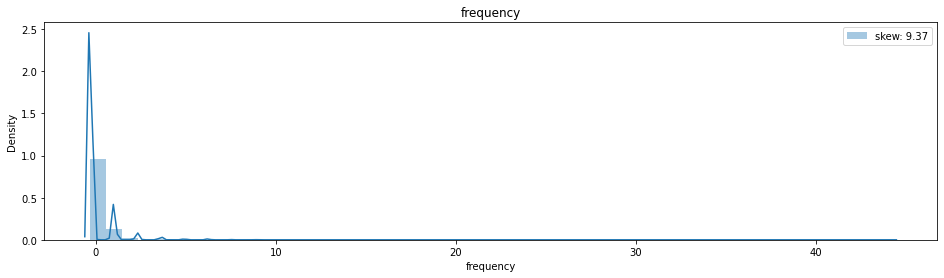

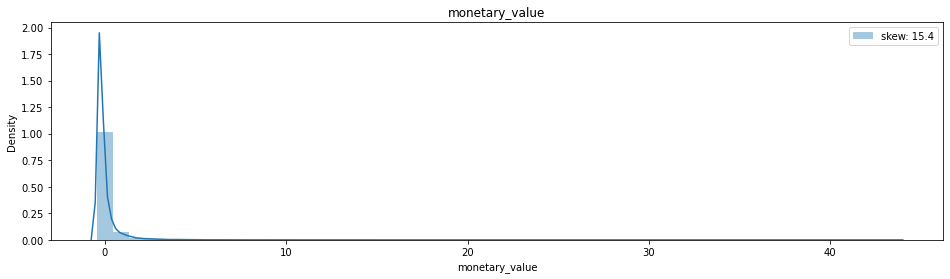

In [31]:
# réprésentation avec un displot de la normalisation
for col in cols_to_scale:
    plt.figure(figsize=(16, 4))
    sns.distplot(rfm_scaled[col], label="skew: "+str(np.round(rfm_scaled[col].skew(),2)))
    plt.title(col)
    plt.legend()

In [32]:
for col in cols_to_scale:
        w, pvalue = st.shapiro(rfm_scaled[col])
        seuil = 0.05
        print(f'{col :-<50} {w} {pvalue}')
        if pvalue > seuil:
            print(
                "On ne peux pas rejetter H0: la distribution suit une loi normale")
        else:
            print(
                "On rejette H0 : la distribution ne suit pas une loi normale")

recency------------------------------------------- 0.9597419500350952 0.0
On rejette H0 : la distribution ne suit pas une loi normale
frequency----------------------------------------- 0.31875282526016235 0.0
On rejette H0 : la distribution ne suit pas une loi normale
monetary_value------------------------------------ 0.3039640188217163 0.0
On rejette H0 : la distribution ne suit pas une loi normale


recency


<Figure size 432x288 with 0 Axes>

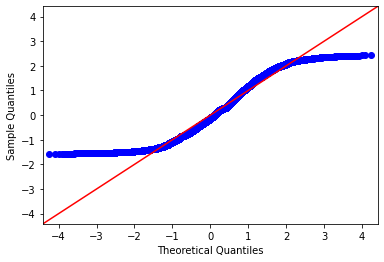

frequency


<Figure size 432x288 with 0 Axes>

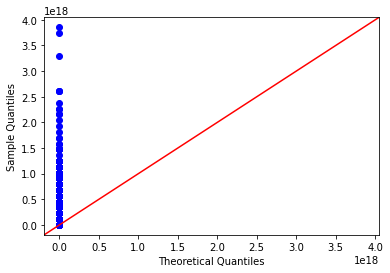

monetary_value


<Figure size 432x288 with 0 Axes>

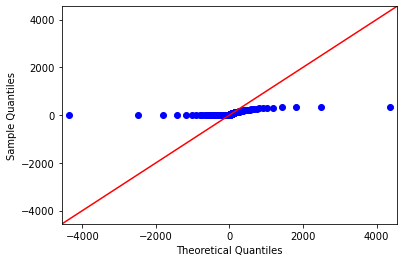

In [33]:
# qqpolot vs. loi normale (droite de Henry)
for col in cols_to_scale:
    plt.figure()
    sm.qqplot(rfm_scaled[col], st.t, fit=True, line="45")
    print(col)
    plt.show()

In [34]:
df_kmeans = rfm_scaled.copy()

In [35]:
df_kmeans = df_kmeans.set_index('customer_unique_id')

In [36]:
# Données
X_kmeans = df_kmeans.select_dtypes('number')

#  Kmeans Clustering
## Kmeans RFM (3 variables)

In [37]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(X_kmeans)
                for k in range(1, 15)]
inertias = [model.inertia_ for model in kmeans_per_k]

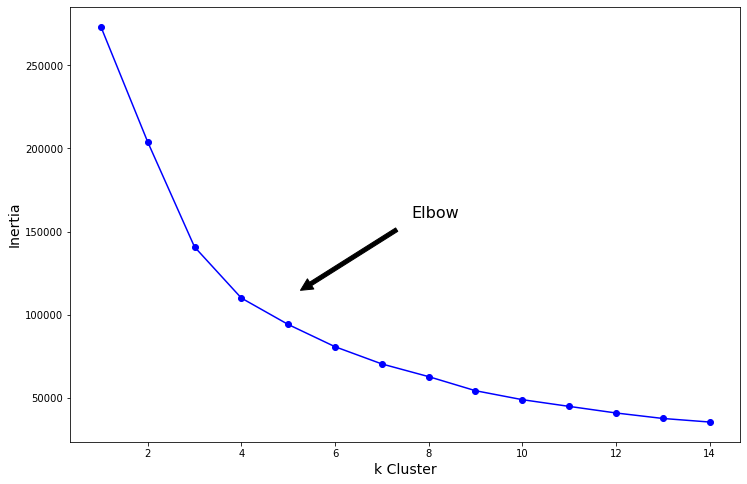

In [38]:
# plot inertia as a function of k and analyze the resulting curve.
plt.figure(figsize=(12, 8))
plt.plot(range(1, 15), inertias, 'bo-')
plt.xlabel('k Cluster', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.annotate('Elbow',
             xy=(5, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords="figure fraction",
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.show()

In [39]:
k = 4
kmeans = KMeans(n_clusters=k,random_state=0).fit(X_kmeans)

In [40]:
df_kmeans['Kmeans_cluster'] = kmeans.labels_

In [41]:
df_kmeans.head()

recency  frequency  monetary_value  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2 -0.824816   -0.30123       -0.151566   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.804923   -0.30123       -0.411915   
0000f46a3911fa3c0805444483337064  1.999912   -0.30123       -0.277939   
0000f6ccb0745a6a4b88665a16c9f078  0.567656   -0.30123       -0.374625   
0004aac84e0df4da2b147fca70cf8255  0.348839   -0.30123       -0.026759   

                                  Kmeans_cluster  
customer_unique_id                                
0000366f3b9a7992bf8c76cfdf3221e2               1  
0000b849f77a49e4a4ce2b2a4ca5be3f               1  
0000f46a3911fa3c0805444483337064               3  
0000f6ccb0745a6a4b88665a16c9f078               3  
0004aac84e0df4da2b147fca70cf8255               3

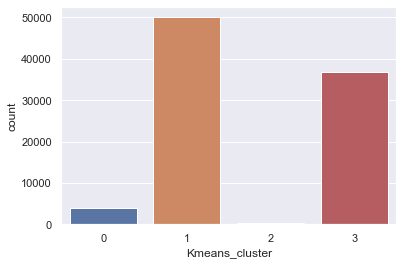

In [42]:
# repartition nb de pays /cluster
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Kmeans_cluster", data=df_kmeans)

In [43]:
# les moyennes des groupes Kmeans par feature
df_kmeans_gb = df_kmeans.groupby(["Kmeans_cluster"]).mean()
df_kmeans_gb

recency  frequency  monetary_value
Kmeans_cluster                                     
0              -0.035896   3.016412        1.628741
1              -0.723080  -0.156861       -0.105939
2              -0.049670   8.046166       13.592362
3               0.984330  -0.150199       -0.105150

In [44]:
rfm 

customer_unique_id  recency  frequency  monetary_value
0      0000366f3b9a7992bf8c76cfdf3221e2      234        1.0          141.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f      237        1.0           27.19
2      0000f46a3911fa3c0805444483337064      660        1.0           86.22
3      0000f6ccb0745a6a4b88665a16c9f078      444        1.0           43.62
4      0004aac84e0df4da2b147fca70cf8255      411        1.0          196.89
...                                 ...      ...        ...             ...
91069  fffcf5a5ff07b0908bd4e2dbc735a684      570        2.0         4134.84
91070  fffea47cd6d3cc0a88bd621562a9d061      385        1.0           84.58
91071  ffff371b4d645b6ecea244b27531430a      691        1.0          112.46
91072  ffff5962728ec6157033ef9805bacc48      242        1.0          133.69
91073  ffffd2657e2aad2907e67c3e9daecbeb      606        1.0           71.56

[91074 rows x 4 columns]

In [45]:
df_kmeans_real_val = pd.merge(rfm,df_kmeans['Kmeans_cluster'], on="customer_unique_id")

In [46]:
df_kmeans_real_val

customer_unique_id  recency  frequency  monetary_value  \
0      0000366f3b9a7992bf8c76cfdf3221e2      234        1.0          141.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      237        1.0           27.19   
2      0000f46a3911fa3c0805444483337064      660        1.0           86.22   
3      0000f6ccb0745a6a4b88665a16c9f078      444        1.0           43.62   
4      0004aac84e0df4da2b147fca70cf8255      411        1.0          196.89   
...                                 ...      ...        ...             ...   
91069  fffcf5a5ff07b0908bd4e2dbc735a684      570        2.0         4134.84   
91070  fffea47cd6d3cc0a88bd621562a9d061      385        1.0           84.58   
91071  ffff371b4d645b6ecea244b27531430a      691        1.0          112.46   
91072  ffff5962728ec6157033ef9805bacc48      242        1.0          133.69   
91073  ffffd2657e2aad2907e67c3e9daecbeb      606        1.0           71.56   

       Kmeans_cluster  
0                   1  
1                   1  
2                   3  
3                   3  
4                   3  
...               ...  
91069               0  
91070               3  
91071               3  
91072               1  
91073               3  

[91074 rows x 5 columns]

In [47]:
# les moyennes des groupes Kmeans par feature
df_kmeans_real_val_gb = df_kmeans_real_val.groupby(["Kmeans_cluster"]).mean()
df_kmeans_real_val_gb

recency  frequency  monetary_value
Kmeans_cluster                                       
0               352.977829   3.537252      926.302503
1               249.342835   1.110410      162.003128
2               350.900474   7.383886     6197.470521
3               506.839079   1.115504      162.350692

<AxesSubplot:ylabel='Kmeans_cluster'>

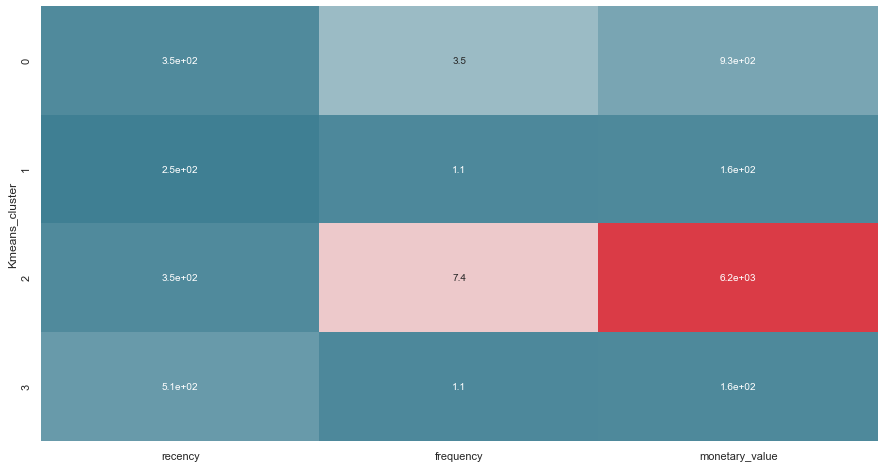

In [48]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_kmeans_gb, cmap=cmap, annot=df_kmeans_real_val_gb,
            annot_kws={'size': 10}, cbar=None)

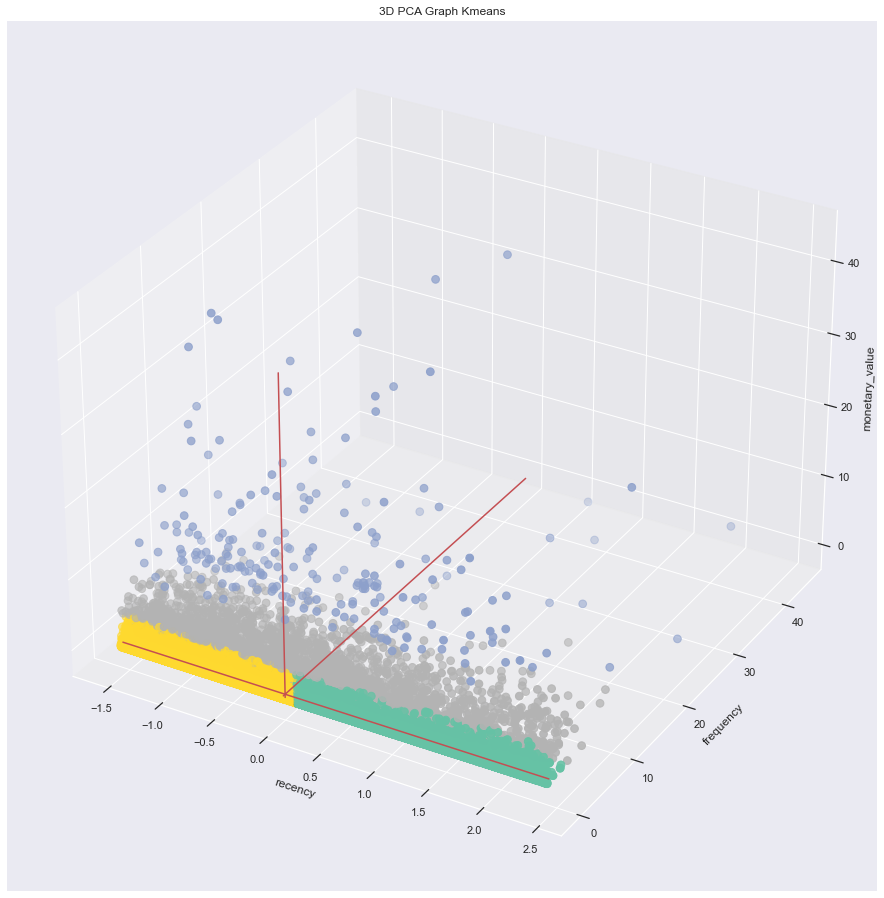

In [49]:
my_color = df_kmeans['Kmeans_cluster']


# Plot initialisation
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_kmeans['recency'], df_kmeans['frequency'],
           df_kmeans['monetary_value'], c=my_color, cmap="Set2_r", s=60)

# make simple, bare axis lines through space:
xAxisLine = ((min(df_kmeans['recency']), max(
    df_kmeans['recency'])), (0, 0), (0, 0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(df_kmeans['frequency']), max(
    df_kmeans['frequency'])), (0, 0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0, 0),
             (min(df_kmeans['monetary_value']), max(df_kmeans['monetary_value'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')


# label the axes
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary_value")
ax.set_title("3D PCA Graph Kmeans")
plt.show()

## Kmeans Recense / Frequence

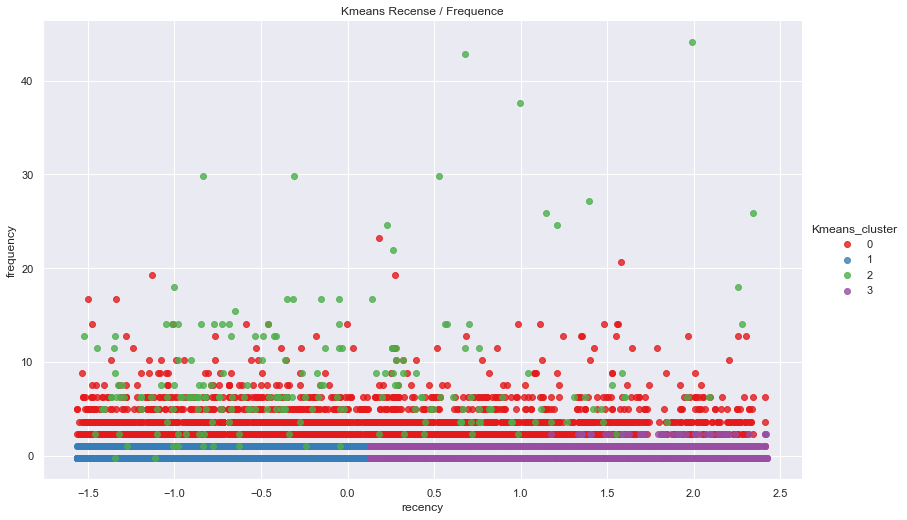

In [50]:
sns.set()
sns.lmplot(
    x='recency',
    y='frequency',
    data=df_kmeans,
    hue='Kmeans_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('Kmeans Recense / Frequence')
plt.show()

## Kmeans Recense / Montant

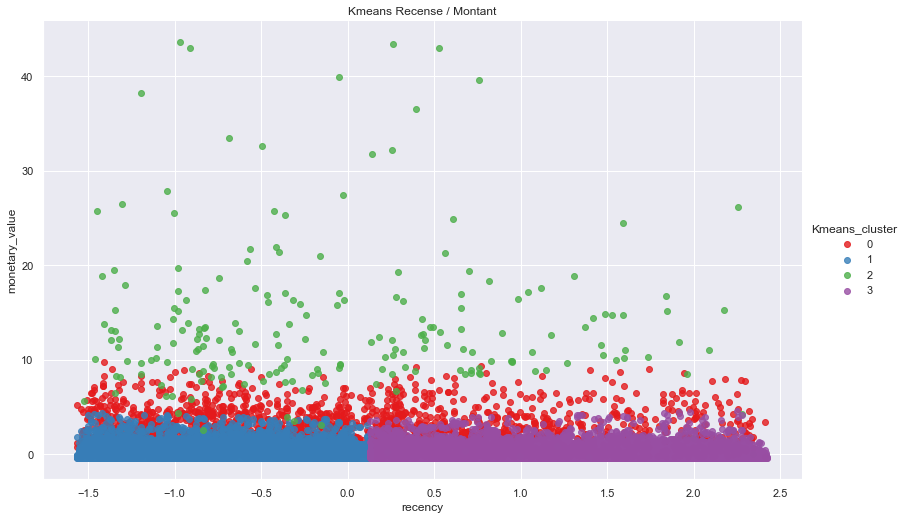

In [51]:
sns.set()
sns.lmplot(
    x='recency',
    y='monetary_value',
    data=df_kmeans,
    hue='Kmeans_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('Kmeans Recense / Montant')
plt.show()

## Kmeans Frequence / Montant

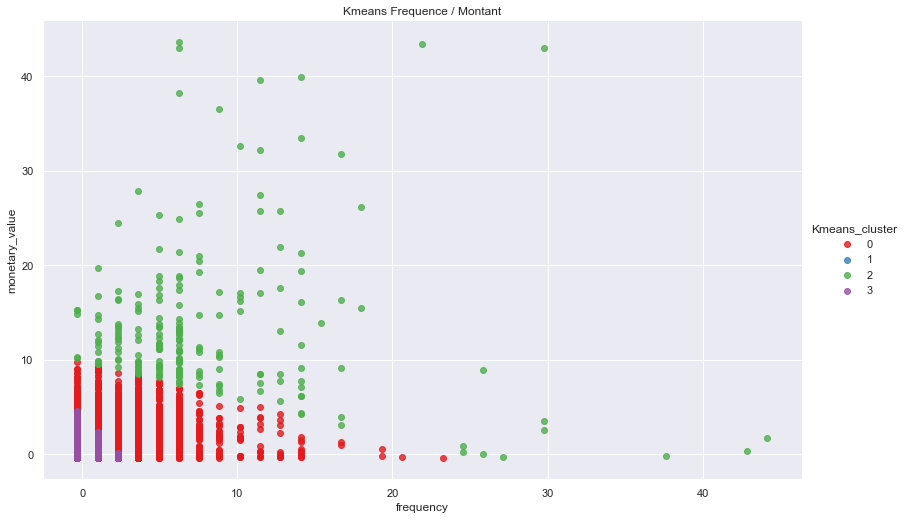

In [52]:
sns.set()
sns.lmplot(
    x='frequency',
    y='monetary_value',
    data=df_kmeans,
    hue='Kmeans_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('Kmeans Frequence / Montant')
plt.show()

# Classification ascendante hiérarchique (CAH)

In [53]:
df_CAH = rfm_scaled.copy()

In [54]:
df_CAH = df_CAH.set_index('customer_unique_id')

In [55]:
# Définition du nombre de lots
batch_size = 10000

# Définition du nombre de clusters
n_clusters = 5

# Initialisation de l'agglomérative clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Boucle pour traiter les données par lots
for i in range(0, df_CAH.shape[0], batch_size):
    batch = df_CAH.iloc[i:i + batch_size, :]
    batch_labels = agg_clustering.fit_predict(batch)
    if i == 0:
        labels = batch_labels
    else:
        labels = np.concatenate([labels, batch_labels])

# Ajout des étiquettes au jeu de données
df_CAH["CAH_cluster"] = labels

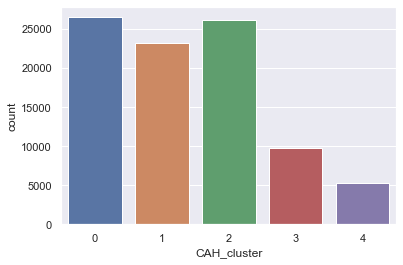

In [56]:
# repartition nb de CLIENTS /cluster
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="CAH_cluster", data=df_CAH)

In [57]:
# les moyennes des groupes Kmeans par feature
df_CAH_gb = df_CAH.groupby(["CAH_cluster"]).mean()
df_CAH_gb

recency  frequency  monetary_value
CAH_cluster                                     
0           -0.307778   0.096095        0.048565
1            0.332883   0.008845       -0.007626
2            0.403509  -0.092032       -0.086660
3           -0.674348  -0.185581        0.012086
4           -0.657216   0.275749        0.193981

In [58]:
df_CAH_real_val = pd.merge(rfm,df_CAH["CAH_cluster"], on="customer_unique_id")

In [59]:
# les moyennes des groupes Kmeans par feature
df_CAH_gb_real_val_gb = df_CAH_real_val.groupby(["CAH_cluster"]).mean()
df_CAH_gb_real_val_gb

recency  frequency  monetary_value
CAH_cluster                                       
0            311.974967   1.303864      230.077689
1            408.593639   1.237137      205.320023
2            419.244939   1.159989      170.497665
3            256.692174   1.088445      214.004860
4            259.275810   1.441259      294.147903

<AxesSubplot:ylabel='CAH_cluster'>

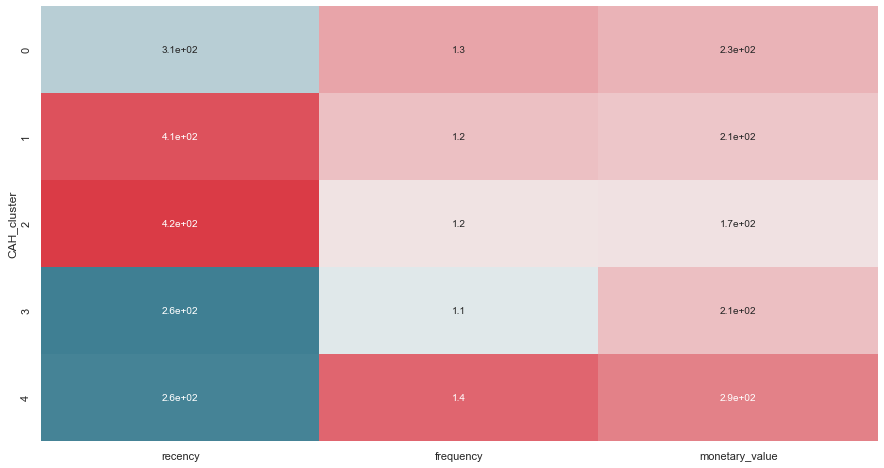

In [60]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_CAH_gb, cmap=cmap, annot=df_CAH_gb_real_val_gb,
            annot_kws={'size': 10}, cbar=None)

## CAH RFM (3 variables)

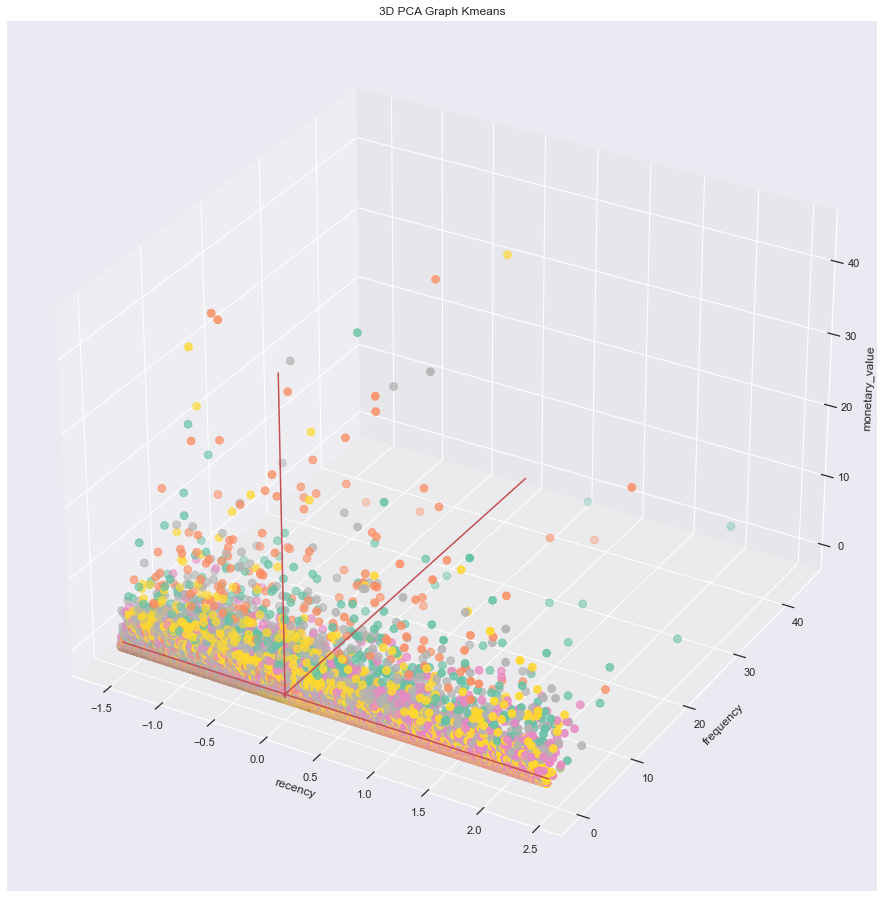

In [61]:
my_color = df_CAH["CAH_cluster"]


# Plot initialisation
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_CAH['recency'], df_CAH['frequency'],
           df_CAH['monetary_value'], c=my_color, cmap="Set2_r", s=60)

# make simple, bare axis lines through space:
xAxisLine = ((min(df_CAH['recency']), max(
    df_CAH['recency'])), (0, 0), (0, 0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(df_CAH['frequency']), max(
    df_CAH['frequency'])), (0, 0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0, 0),
             (min(df_CAH['monetary_value']), max(df_CAH['monetary_value'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')


# label the axes
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary_value")
ax.set_title("3D PCA Graph Kmeans")
plt.show()

## CAH Recense / Frequence

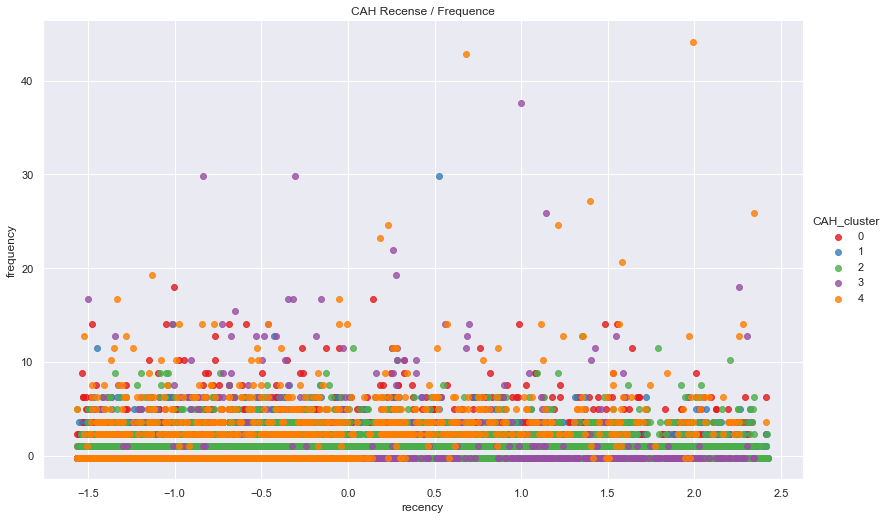

In [62]:
sns.set()
sns.lmplot(
    x='recency',
    y='frequency',
    data=df_CAH,
    hue='CAH_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('CAH Recense / Frequence')
plt.show()

## CAH Recense / Montant

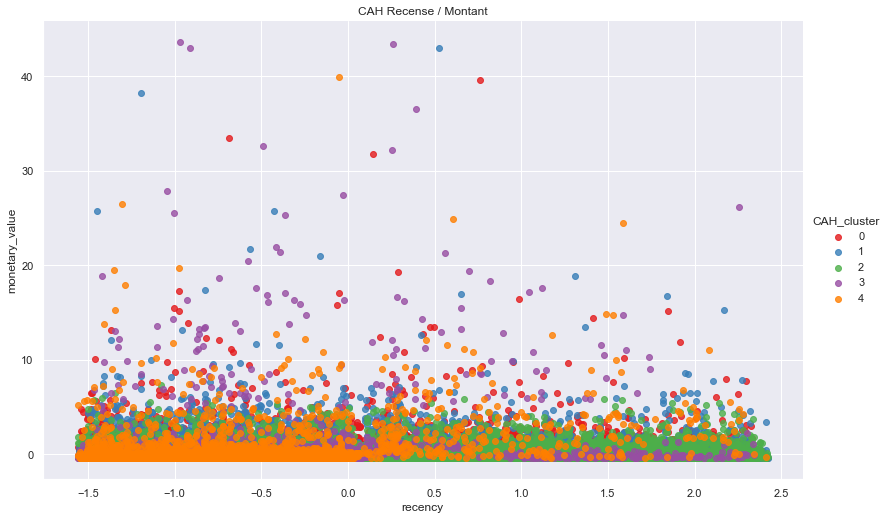

In [63]:
sns.set()
sns.lmplot(
    x='recency',
    y='monetary_value',
    data=df_CAH,
    hue='CAH_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('CAH Recense / Montant')
plt.show()

## CAH Frequence / Montant 

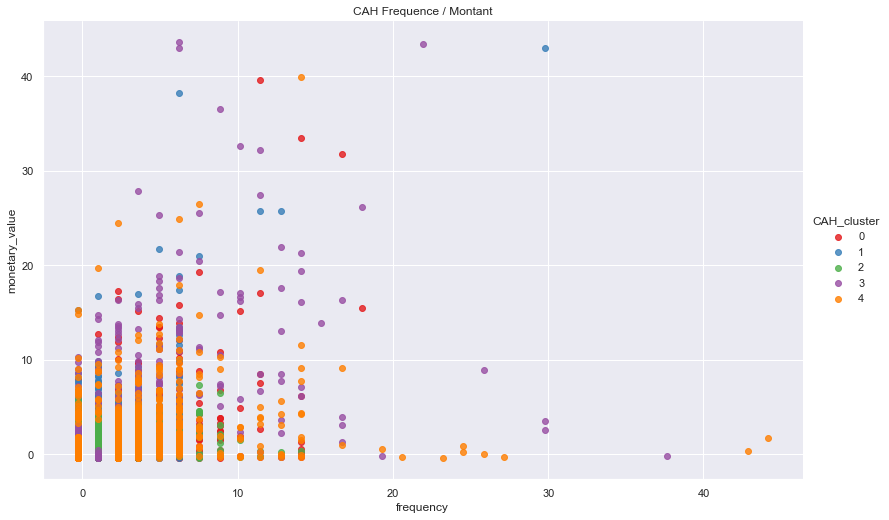

In [64]:
sns.set()
sns.lmplot(
    x='frequency',
    y='monetary_value',
    data=df_CAH,
    hue='CAH_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('CAH Frequence / Montant')
plt.show()

# Analyse Features

In [65]:
df_agg = df.groupby('customer_unique_id').agg({'temps_session': lambda x: x.mean(),  
                                                   'experience_client': lambda x: x.mean(),     
                                                   'temps_livraison_estime': lambda x: x.mean(),
                                                   'review_score': lambda x: x.mean(),
                                                  'temps_de_reponse': lambda x: x.mean(),
                                                  'longueur_comment_message': lambda x: x.mean()})

In [66]:
df.drop(['order_approved_at','order_id','order_item_id','payment_value','temps_session', 'experience_client', 'temps_livraison_estime',
       'review_score', 'temps_de_reponse', 'longueur_comment_message',
       'customer_zip_code_prefix',
       'order_item_id', 'benefice', 'product_weight_g', 'product_volume_cm3',
       'product_category_name_english'],axis=1,inplace=True)

In [67]:
df.columns

Index(['payment_type', 'customer_unique_id', 'bed_bath_table', 'health_beauty',
       'sports_leisure', 'furniture_decor', 'computers_accessories',
       'housewares', 'watches_gifts', 'telephony', 'garden_tools', 'auto',
       'toys', 'cool_stuff', 'perfumery', 'baby', 'electronics', 'stationery',
       'fashion_bags_accessories', 'pet_shop', 'office_furniture',
       'luggage_accessories', 'consoles_games',
       'construction_tools_construction', 'home_appliances',
       'small_appliances', 'musical_instruments', 'home_construction',
       'books_general_interest', 'furniture_living_room', 'food',
       'home_confort', 'audio', 'drinks', 'market_place',
       'construction_tools_lights', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'food_drink', 'fashion_shoes',
       'industry_commerce_and_business', 'books_technical'],
      dtype='object')

In [68]:
df_merge = pd.merge(df_kmeans_real_val,df, on="customer_unique_id")

In [69]:
df_final = pd.merge(df_merge,df_agg, on="customer_unique_id")

In [70]:
df_final.drop(['customer_unique_id'],axis=1,inplace=True)

In [71]:
df_final

recency  frequency  monetary_value  Kmeans_cluster  payment_type  \
0           234        1.0          141.90               1             1   
1           237        1.0           27.19               1             1   
2           660        1.0           86.22               3             1   
3           444        1.0           43.62               3             1   
4           411        1.0          196.89               3             1   
...         ...        ...             ...             ...           ...   
112050      570        2.0         4134.84               0             1   
112051      385        1.0           84.58               3             1   
112052      691        1.0          112.46               3             1   
112053      242        1.0          133.69               1             1   
112054      606        1.0           71.56               3             1   

        bed_bath_table  health_beauty  sports_leisure  furniture_decor  \
0                    1              0               0                0   
1                    0              1               0                0   
2                    0              0               0                0   
3                    0              0               0                0   
4                    0              0               0                0   
...                ...            ...             ...              ...   
112050               0              1               0                0   
112051               0              0               0                0   
112052               0              0               0                0   
112053               0              0               0                0   
112054               0              0               0                0   

        computers_accessories  ...  food_drink  fashion_shoes  \
0                           0  ...           0              0   
1                           0  ...           0              0   
2                           0  ...           0              0   
3                           0  ...           0              0   
4                           0  ...           0              0   
...                       ...  ...         ...            ...   
112050                      0  ...           0              0   
112051                      0  ...           0              0   
112052                      0  ...           0              0   
112053                      0  ...           0              0   
112054                      0  ...           0              0   

        industry_commerce_and_business  books_technical  temps_session  \
0                                    0                0          891.0   
1                                    0                0        26057.0   
2                                    0                0            0.0   
3                                    0                0         1176.0   
4                                    0                0         1270.0   
...                                ...              ...            ...   
112050                               0                0          880.0   
112051                               0                0          504.0   
112052                               0                0          808.0   
112053                               0                0         2466.0   
112054                               0                0        68188.0   

        experience_client  temps_livraison_estime  review_score  \
0                553930.0                910122.0           5.0   
1                283875.0                624856.0           4.0   
2               2223224.0               2343297.0           3.0   
3               1731204.0               2689843.0           4.0   
4               1135394.0               1741988.0           5.0   
...                   ...                     ...           ...   
112050          2377284.0               4675484.0           5.0   


In [72]:
df_final.columns

Index(['recency', 'frequency', 'monetary_value', 'Kmeans_cluster',
       'payment_type', 'bed_bath_table', 'health_beauty', 'sports_leisure',
       'furniture_decor', 'computers_accessories', 'housewares',
       'watches_gifts', 'telephony', 'garden_tools', 'auto', 'toys',
       'cool_stuff', 'perfumery', 'baby', 'electronics', 'stationery',
       'fashion_bags_accessories', 'pet_shop', 'office_furniture',
       'luggage_accessories', 'consoles_games',
       'construction_tools_construction', 'home_appliances',
       'small_appliances', 'musical_instruments', 'home_construction',
       'books_general_interest', 'furniture_living_room', 'food',
       'home_confort', 'audio', 'drinks', 'market_place',
       'construction_tools_lights', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'food_drink', 'fashion_shoes',
       'industry_commerce_and_business', 'books_technical', 'temps_session',
       'experience_client', 'temps_livraison_estime', 'review_score

## Cluster Analysis

In [73]:
df_values = df_final.groupby('Kmeans_cluster')['recency', 'frequency', 'monetary_value','temps_session',
          'experience_client', 'temps_livraison_estime', 'review_score',
          'temps_de_reponse', 'longueur_comment_message'].agg('mean')

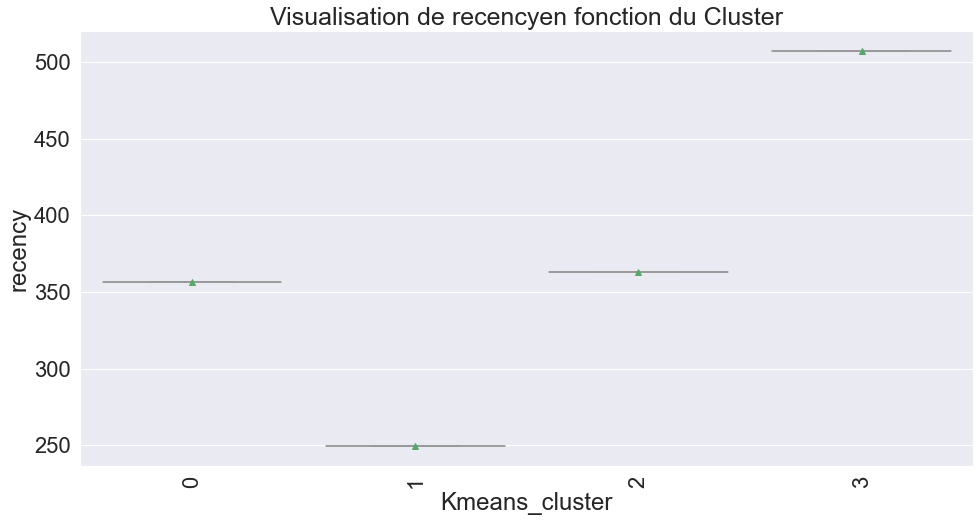

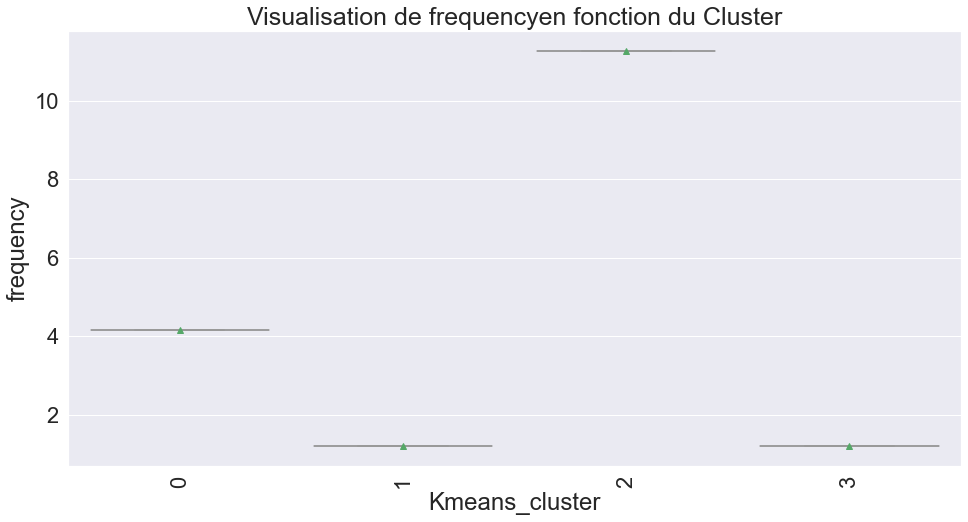

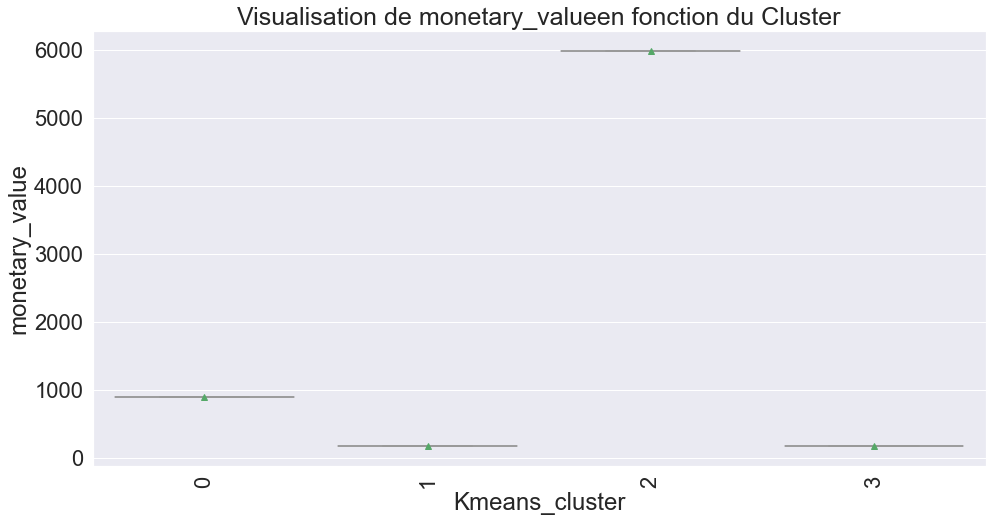

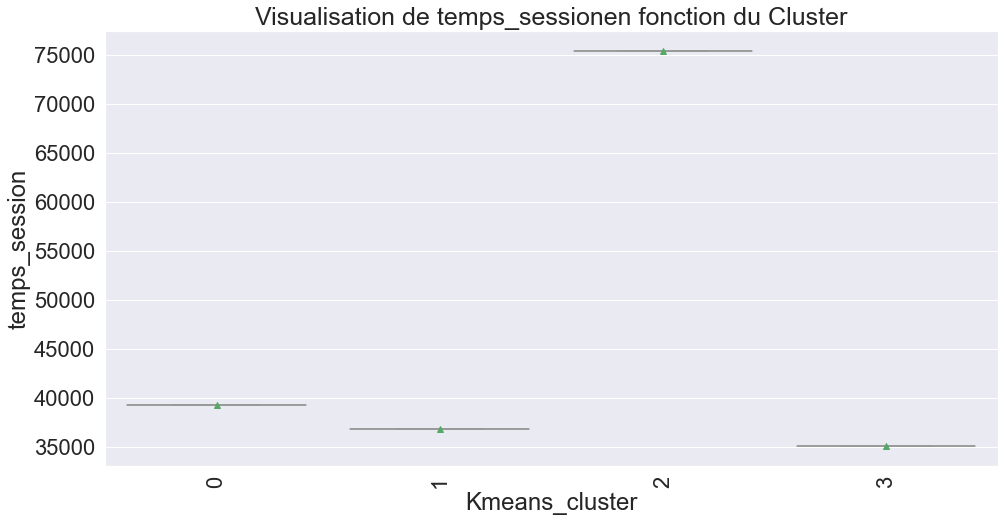

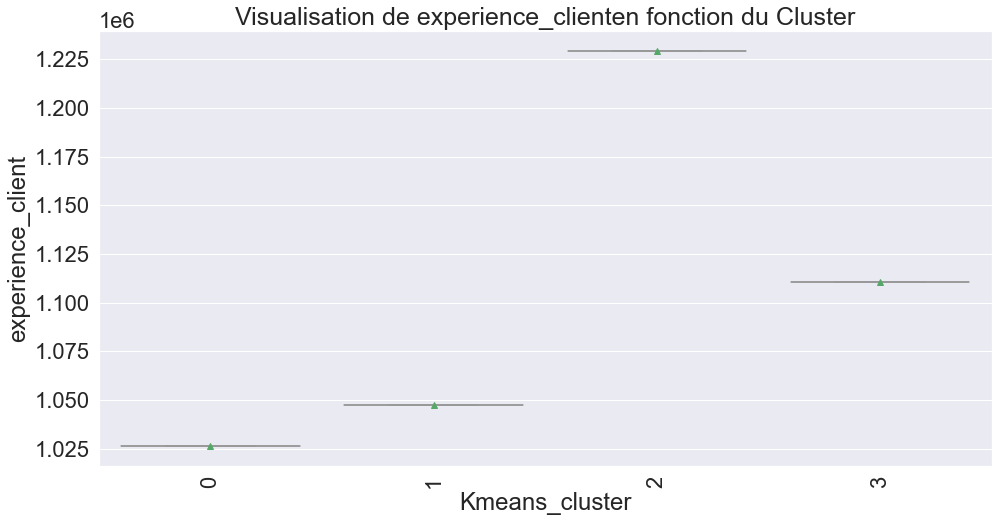

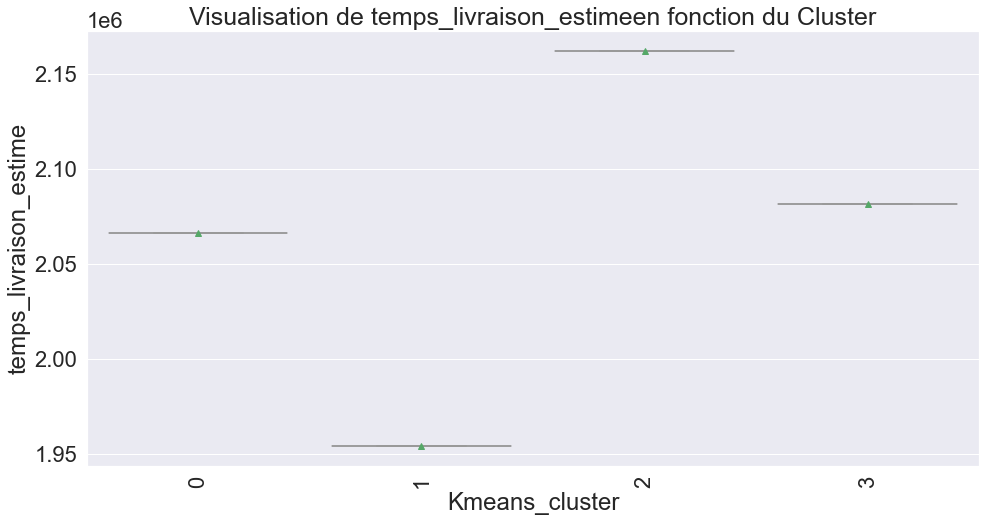

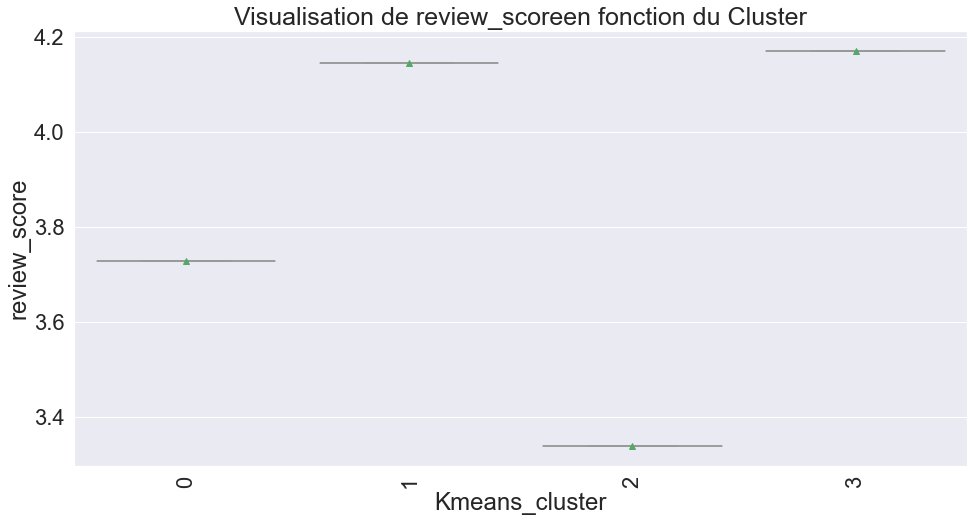

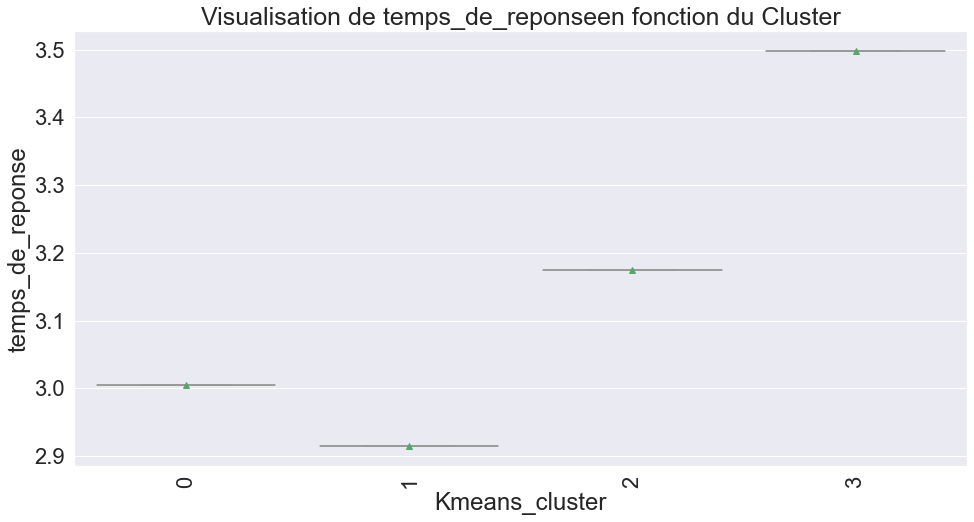

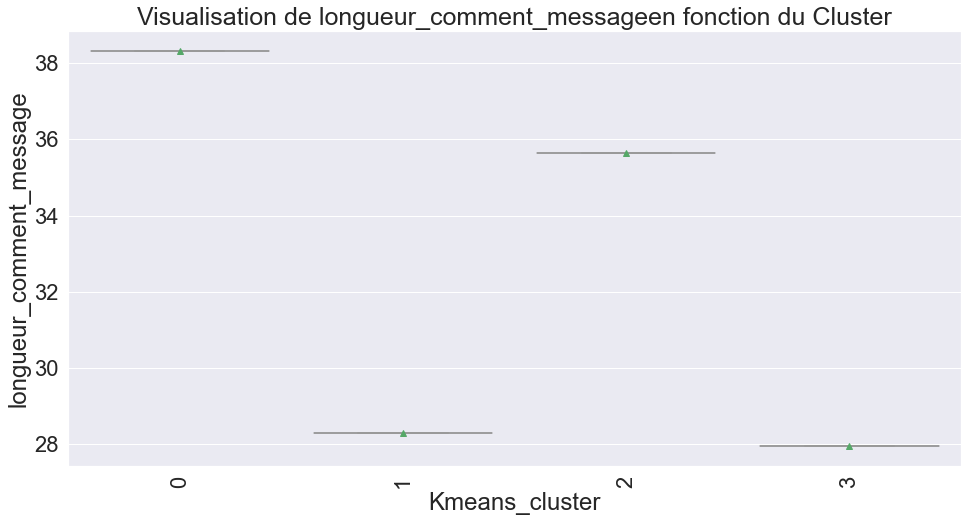

In [75]:
for col in df_values:
    plt.figure(figsize=[16, 8])
    sns.set(font_scale=2)
    sns.boxplot(x=df_values.index, y=col, data=df_values, showmeans=True,color='white')
    plt.title("Visualisation de "+ col + "en fonction du Cluster", fontsize=25)
    plt.xticks(rotation='90')
    plt.show()

In [76]:
df_categ = df_final.groupby('Kmeans_cluster')['bed_bath_table', 'health_beauty', 'sports_leisure',
       'furniture_decor', 'computers_accessories', 'housewares',
       'watches_gifts', 'telephony', 'garden_tools', 'auto', 'toys',
       'cool_stuff', 'perfumery', 'baby', 'electronics', 'stationery',
       'fashion_bags_accessories', 'pet_shop', 'office_furniture',
       'luggage_accessories', 'consoles_games',
       'construction_tools_construction', 'home_appliances',
       'small_appliances', 'musical_instruments', 'home_construction',
       'books_general_interest', 'furniture_living_room', 'food',
       'home_confort', 'audio', 'drinks', 'market_place',
       'construction_tools_lights', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'food_drink', 'fashion_shoes',
       'industry_commerce_and_business', 'books_technical'].agg('sum')

In [79]:
df_categ

bed_bath_table  health_beauty  sports_leisure  \
Kmeans_cluster                                                  
0                         1973            821             962   
1                         5299           5577            4241   
2                          190             69              32   
3                         4166           3137            3438   

                furniture_decor  computers_accessories  housewares  \
Kmeans_cluster                                                       
0                          2040                   1025        1078   
1                          3315                   4175        3490   
2                           178                    225         160   
3                          2911                   2427        2342   

                watches_gifts  telephony  garden_tools  auto  ...  audio  \
Kmeans_cluster                                                ...          
0                         424        238           713   377  ...     13   
1                        3563       2302          1673  2508  ...    204   
2                          53         33           117    30  ...      0   
3                        1957       1937          1921  1305  ...    157   

                drinks  market_place  construction_tools_lights  \
Kmeans_cluster                                                    
0                   76            29                         86   
1                  225           101                        208   
2                    5             2                          0   
3                   54           178                         14   

                kitchen_dining_laundry_garden_furniture  air_conditioning  \
Kmeans_cluster                                                              
0                                                    33                37   
1                                                   147               133   
2                                                     5                 7   
3                                                   101               108   

                food_drink  fashion_shoes  industry_commerce_and_business  \
Kmeans_cluster                                                              
0                       56             30                              27   
1                      124             71                             208   
2                        0              0                               0   
3                       99            166                              28   

                books_technical  
Kmeans_cluster                   
0                             7  
1                           212  
2                             0  
3                            44  

[4 rows x 40 columns]

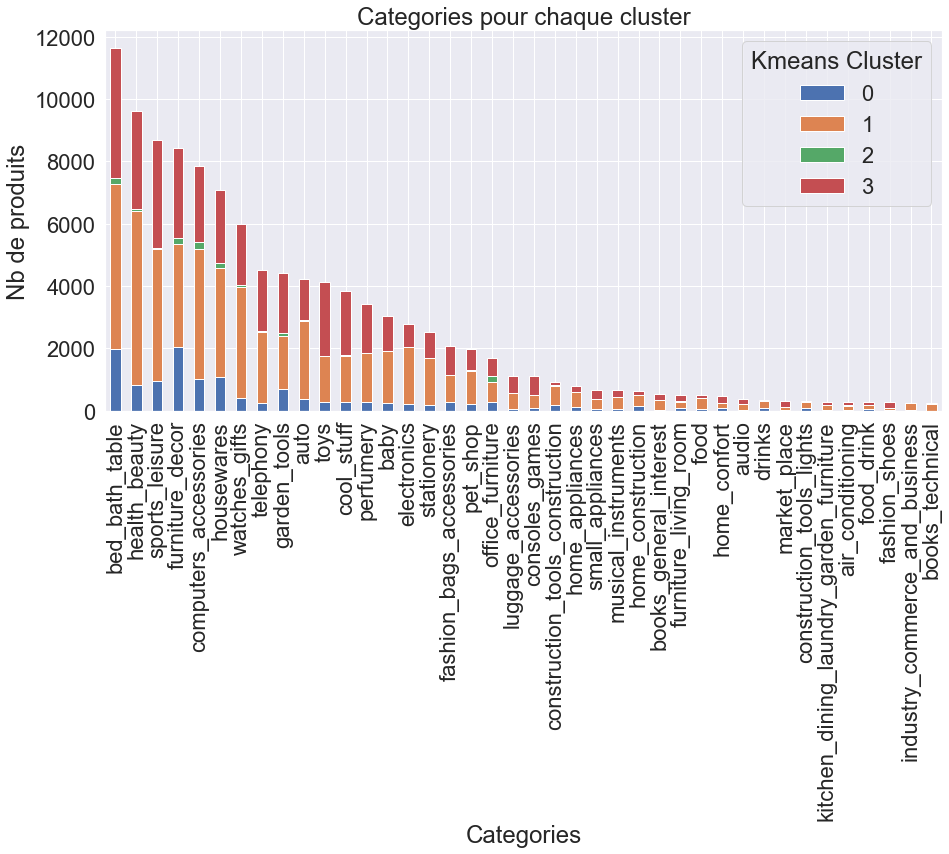

In [86]:
df_categ.T.plot(kind="bar", stacked=True, figsize=(15,7))
plt.legend(title="Kmeans Cluster")
plt.xlabel("Categories")
plt.ylabel("Nb de produits")
plt.title("Categories pour chaque cluster")
plt.show()

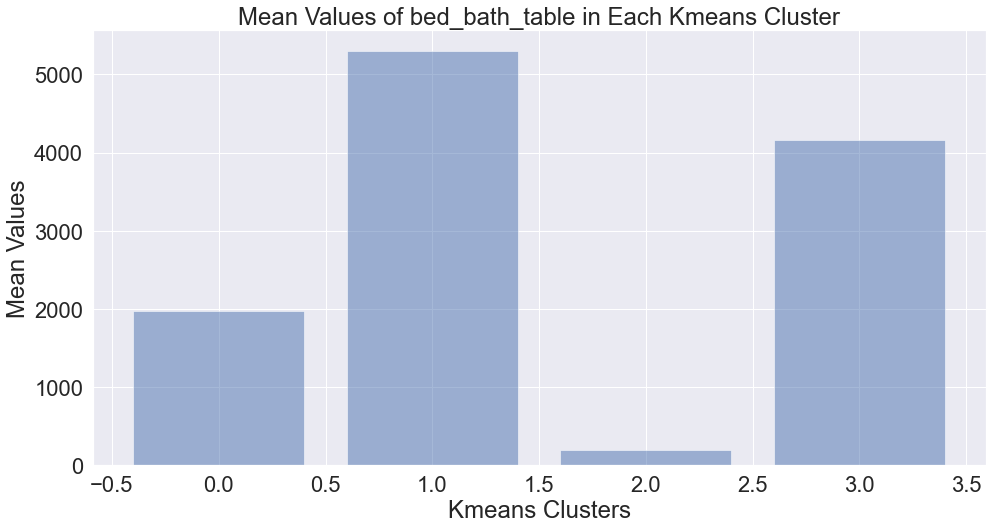

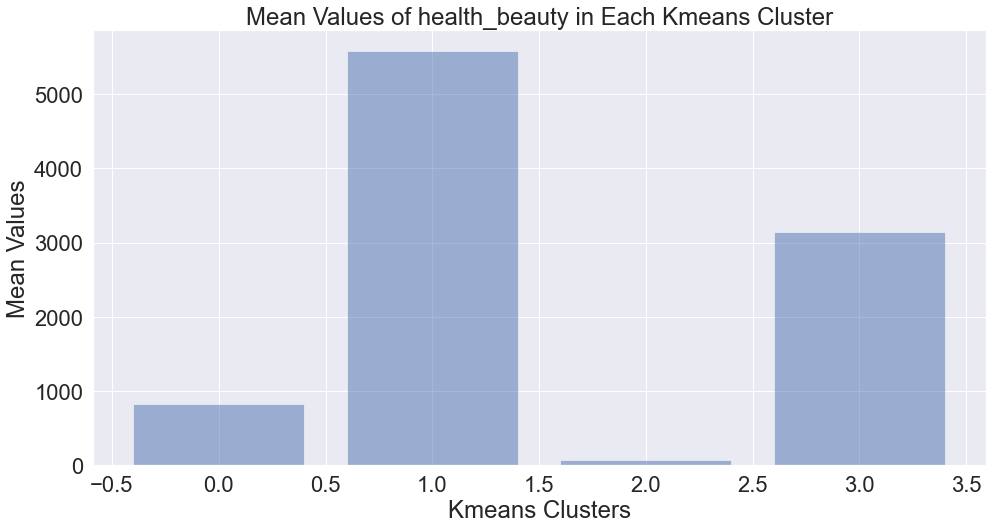

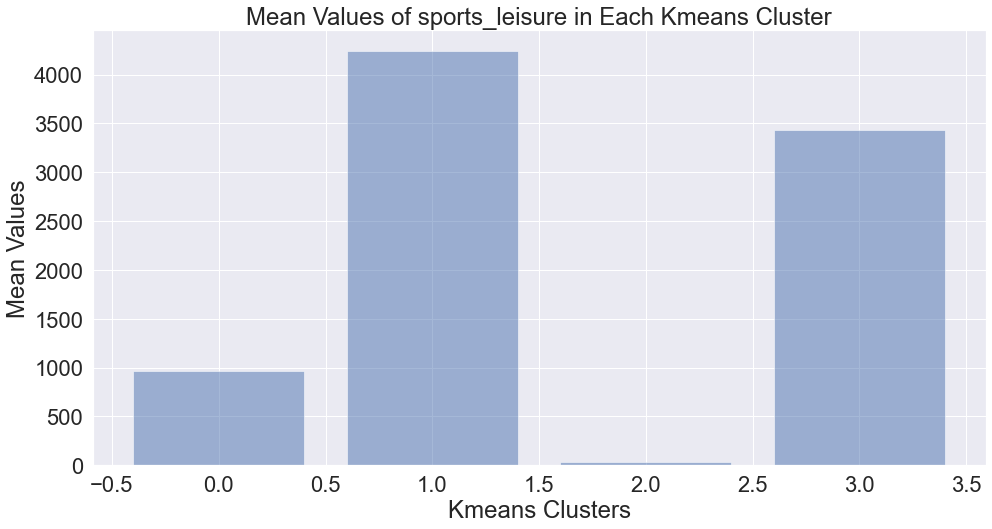

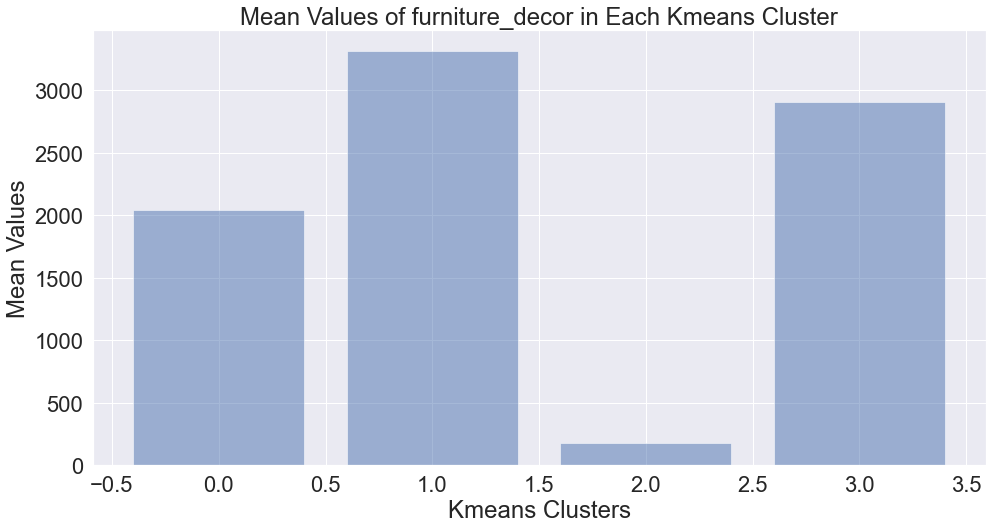

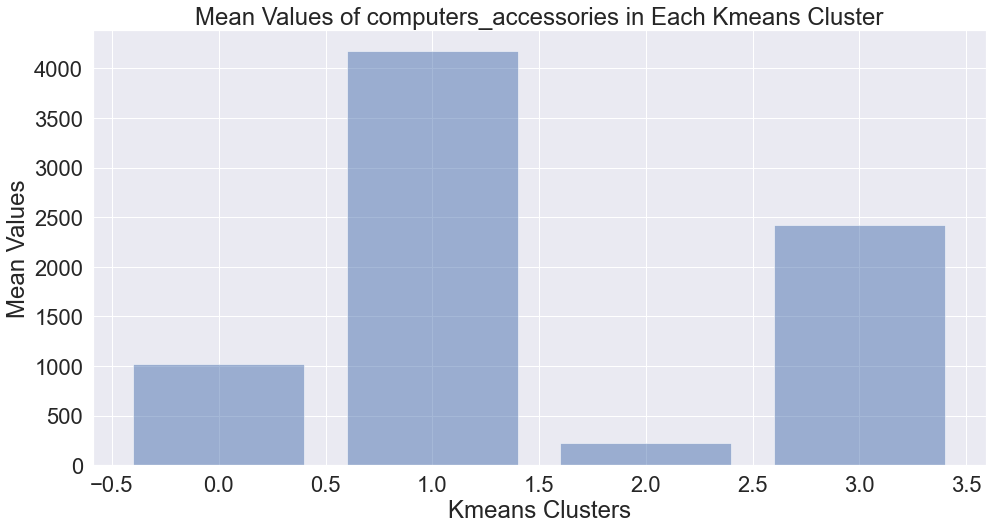

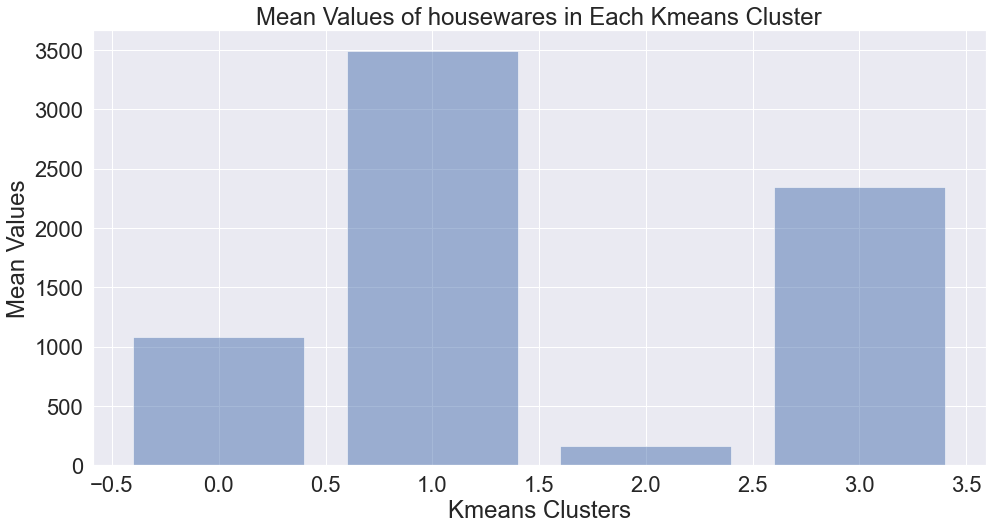

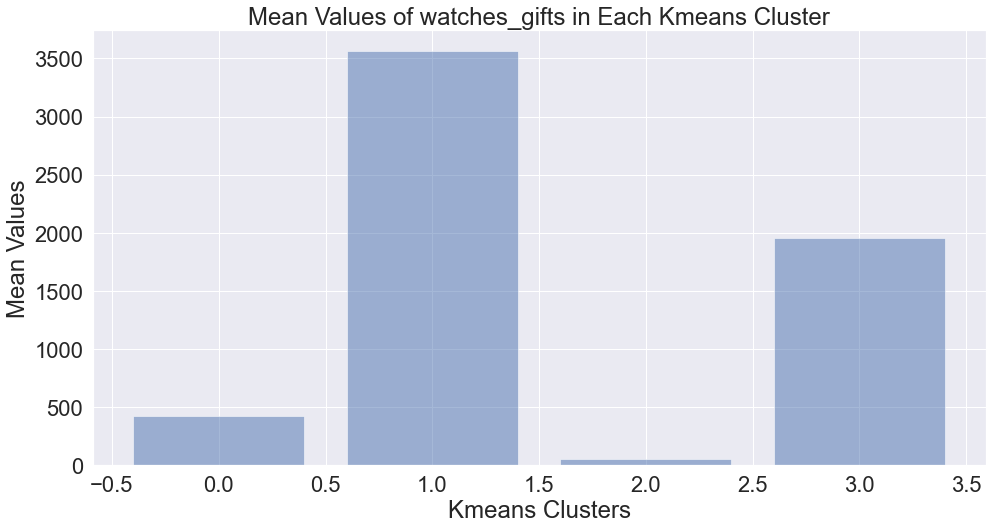

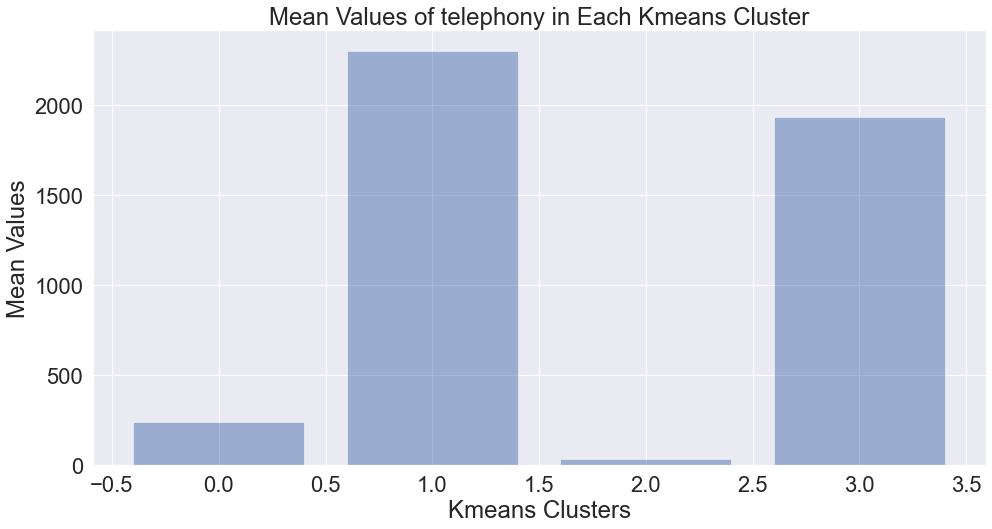

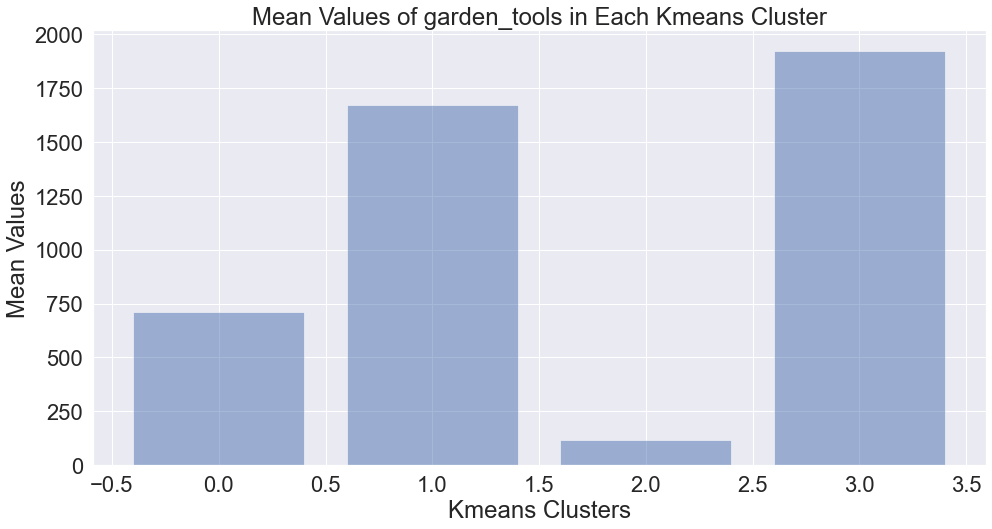

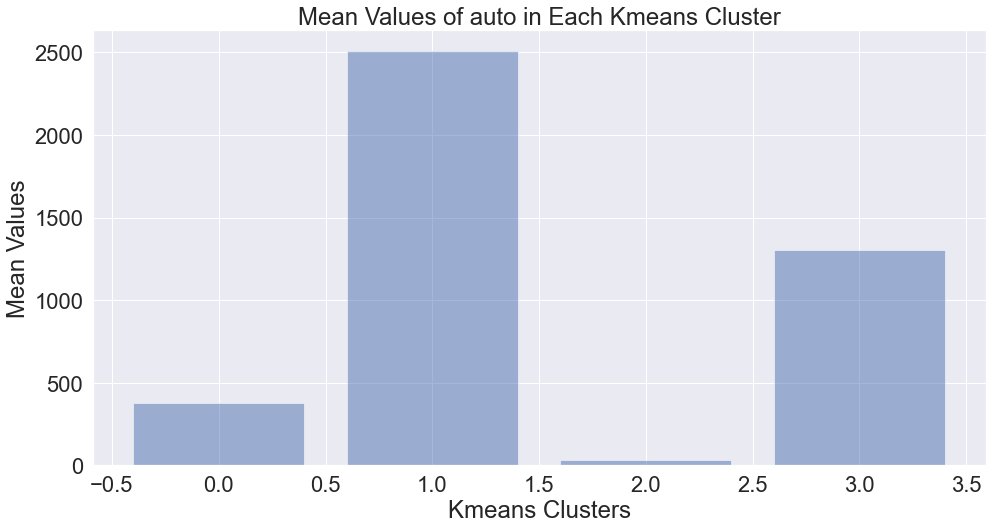

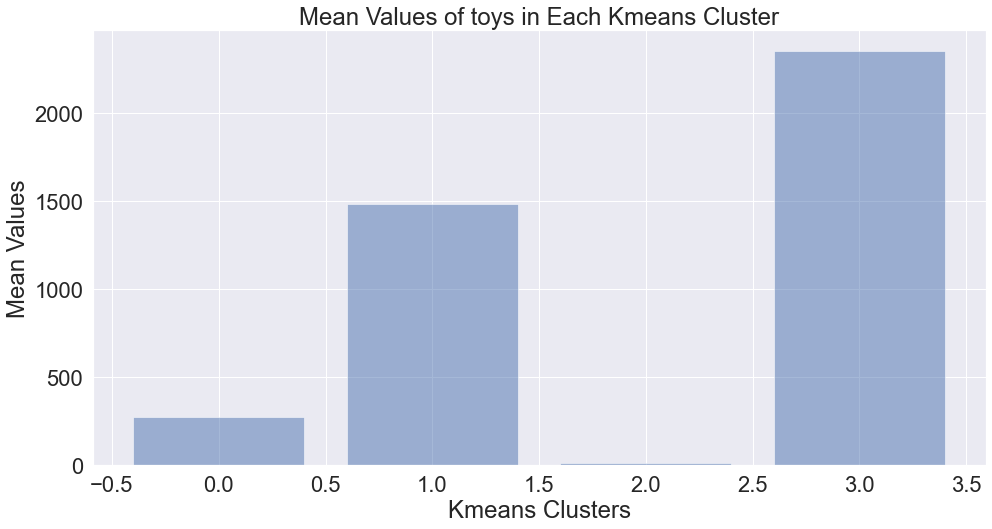

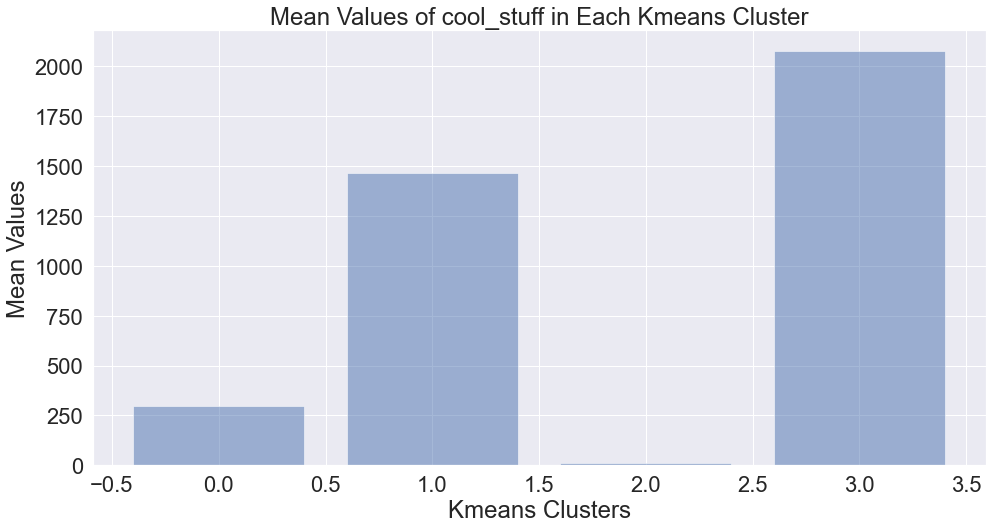

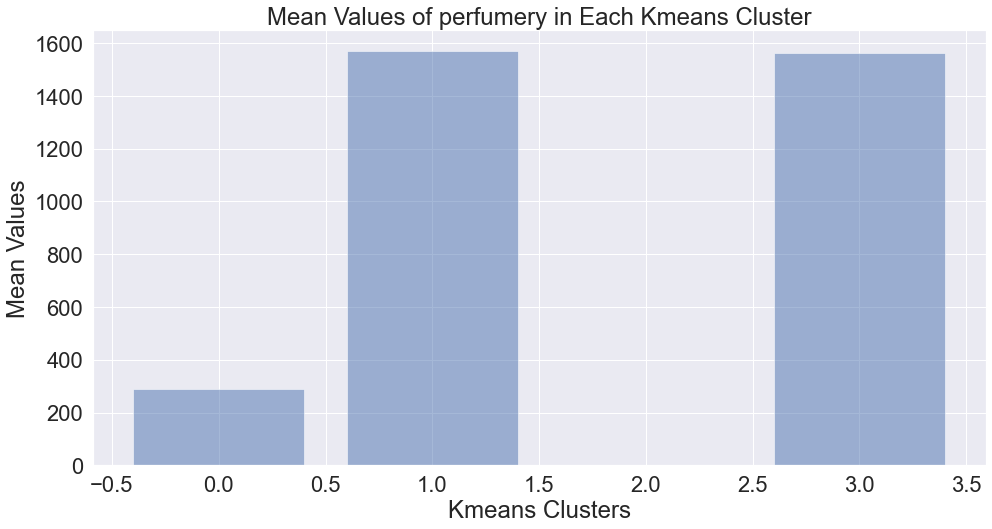

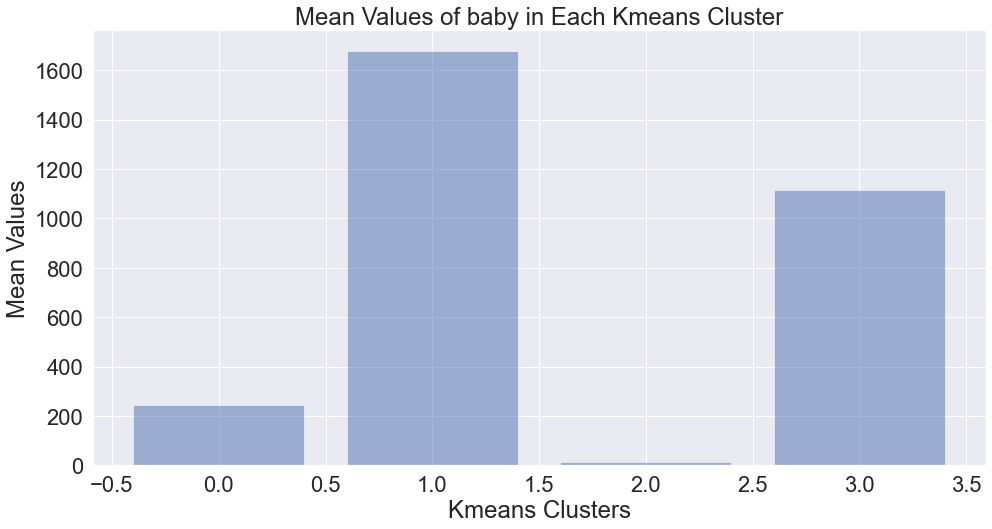

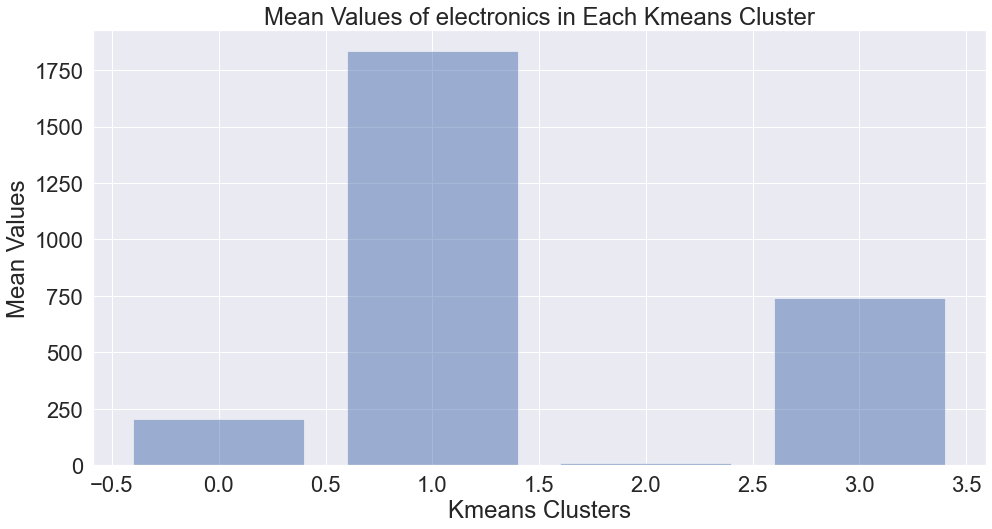

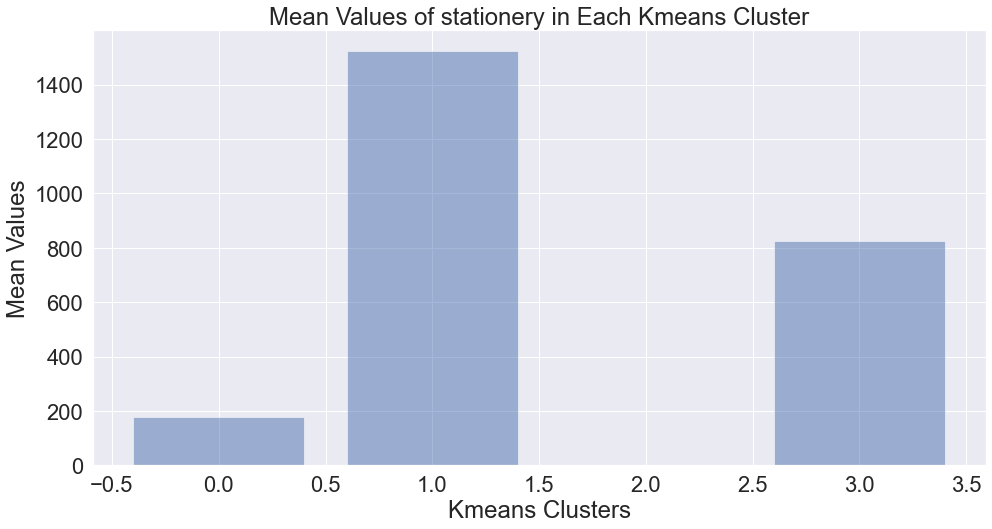

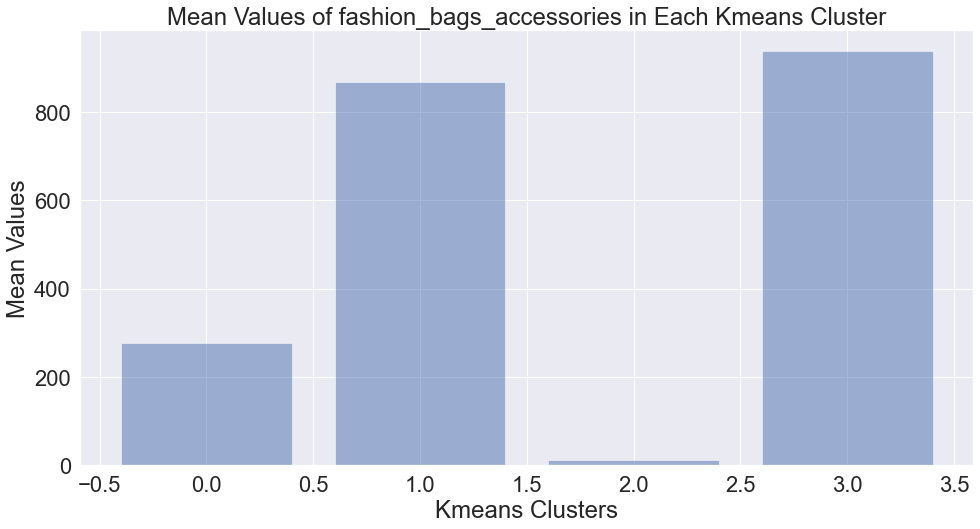

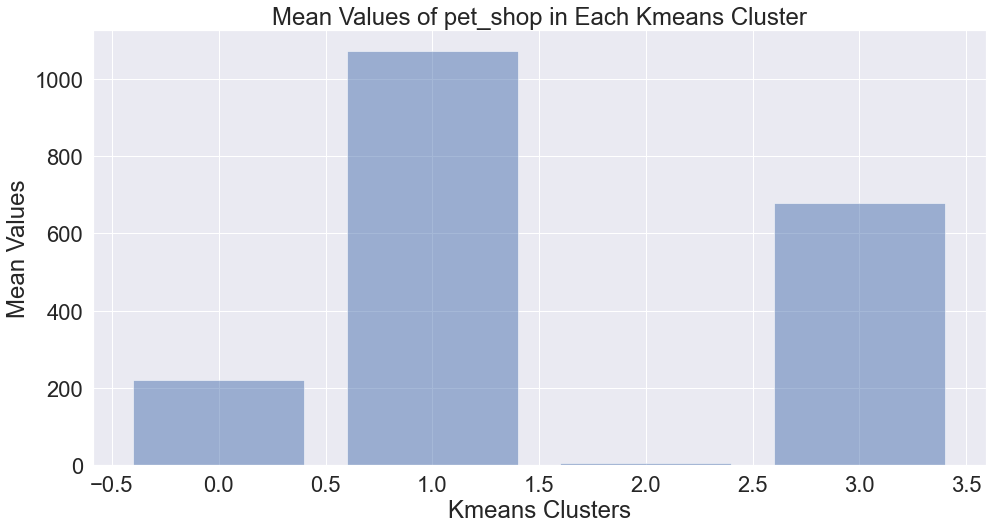

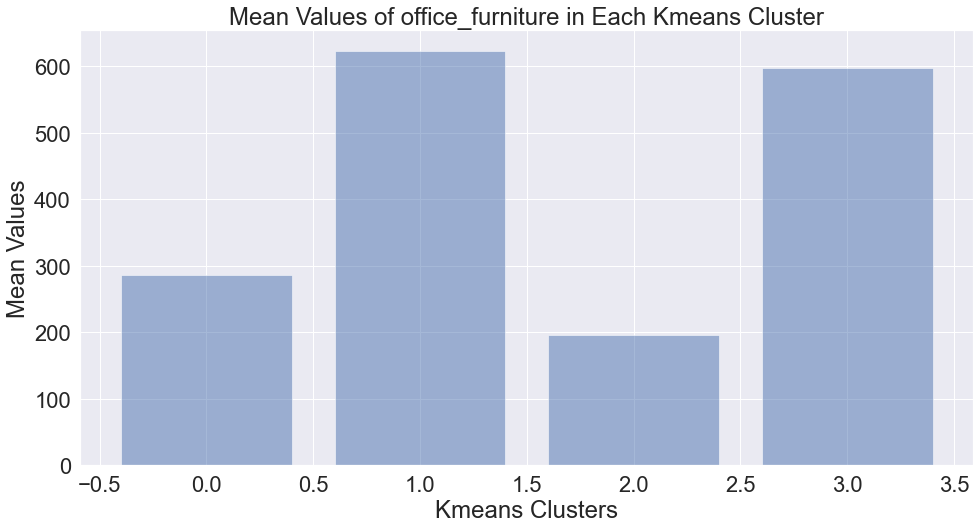

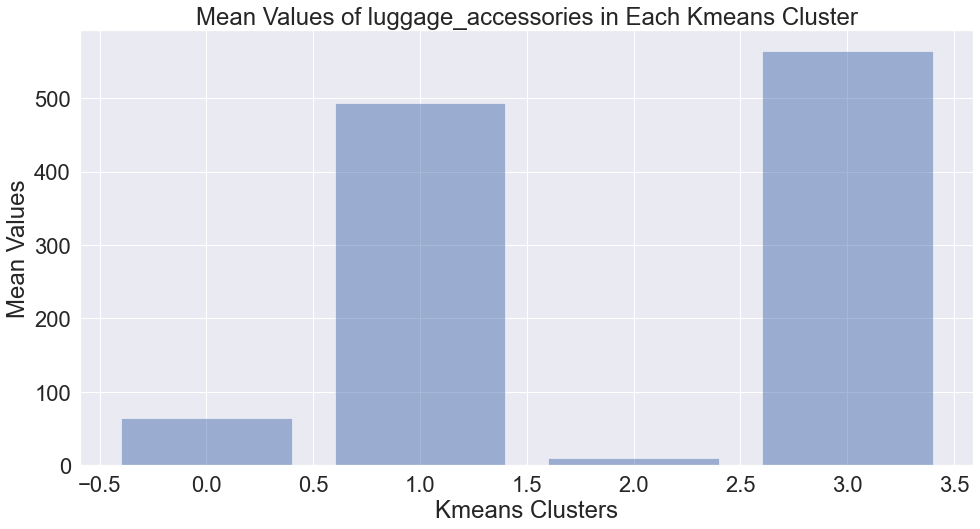

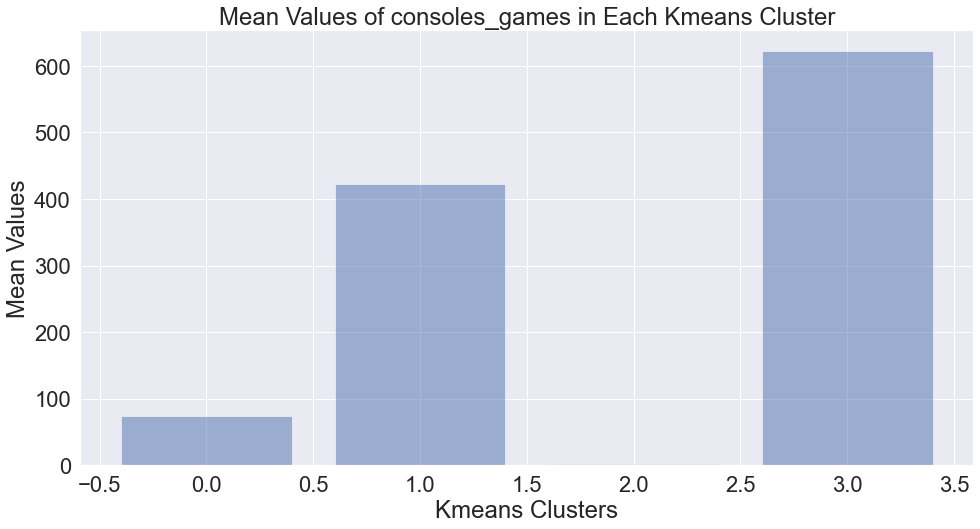

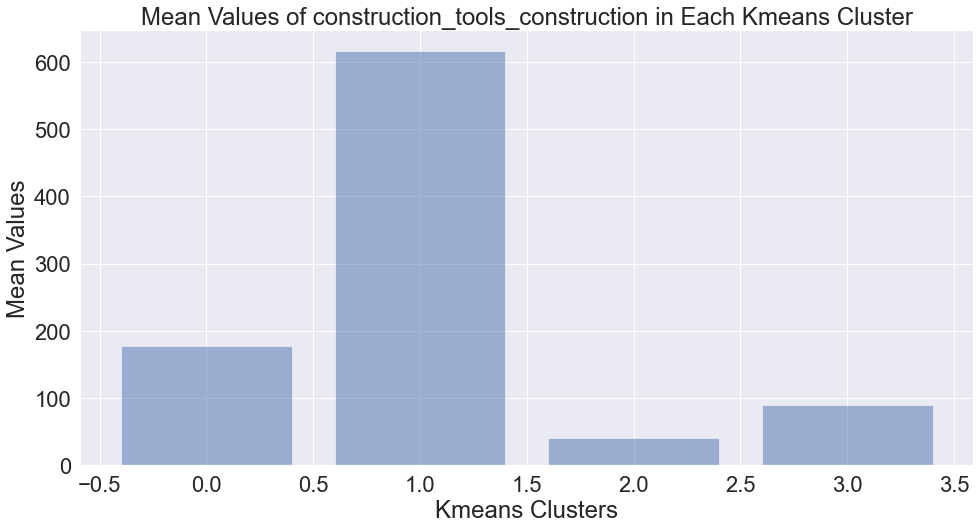

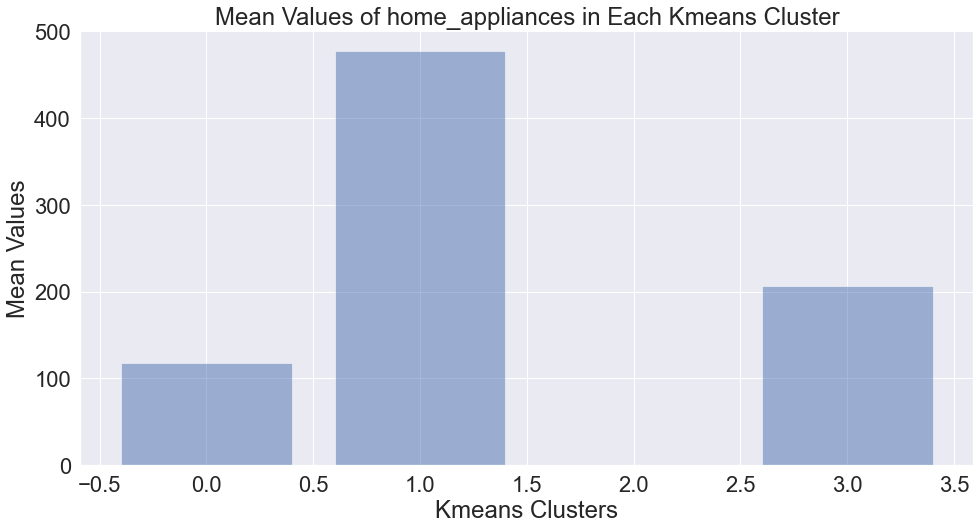

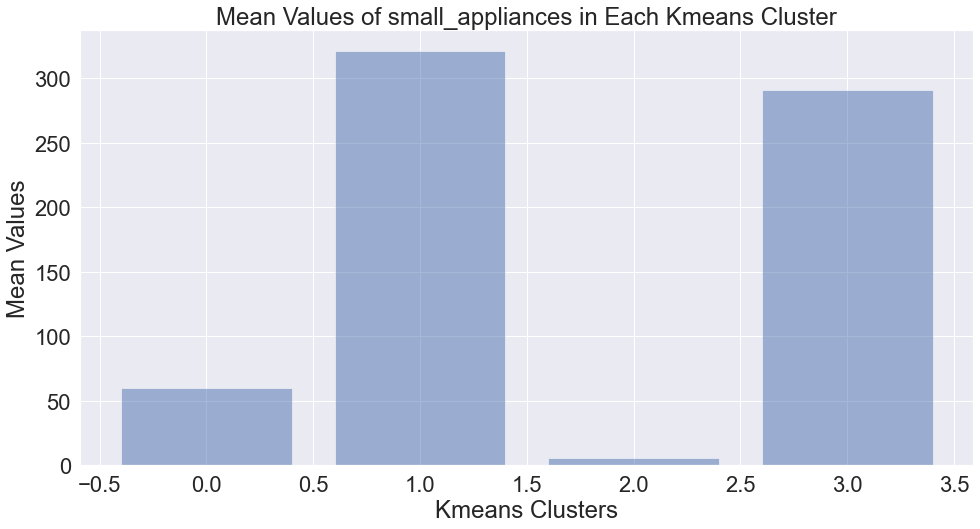

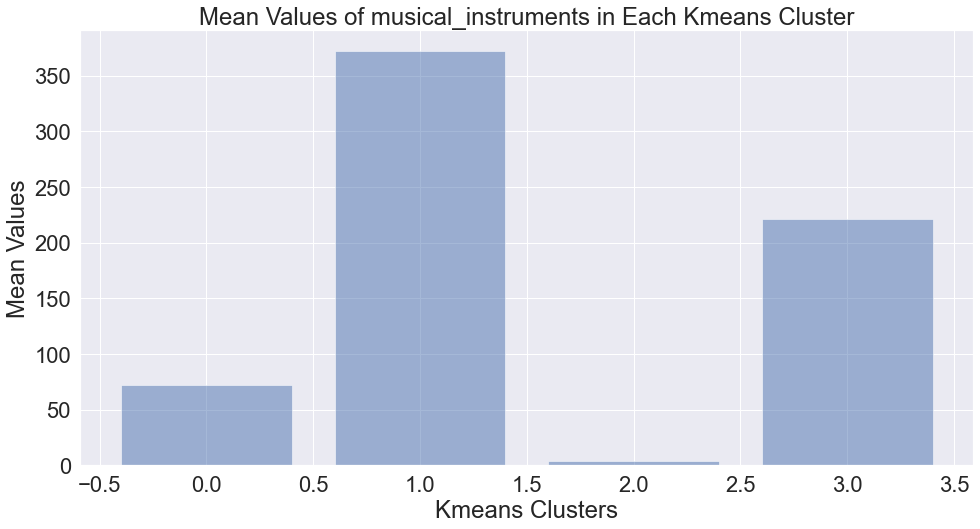

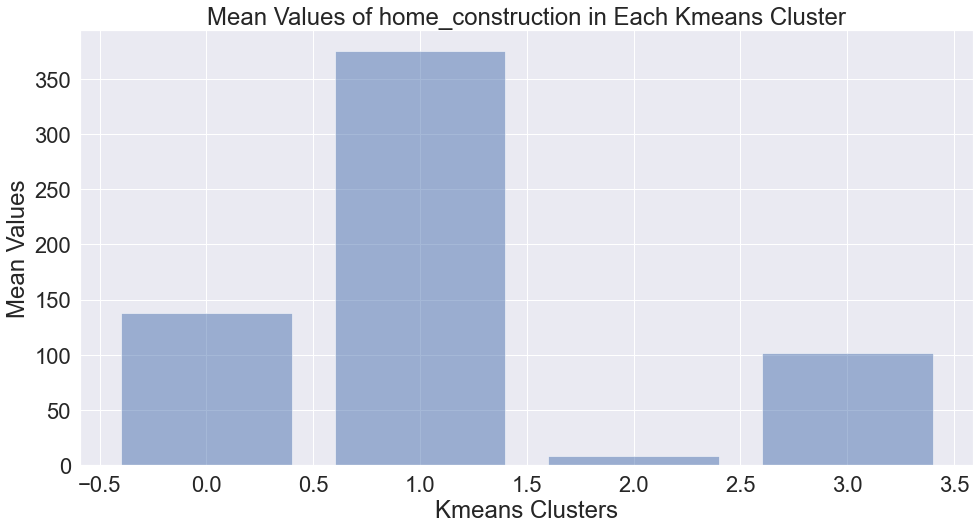

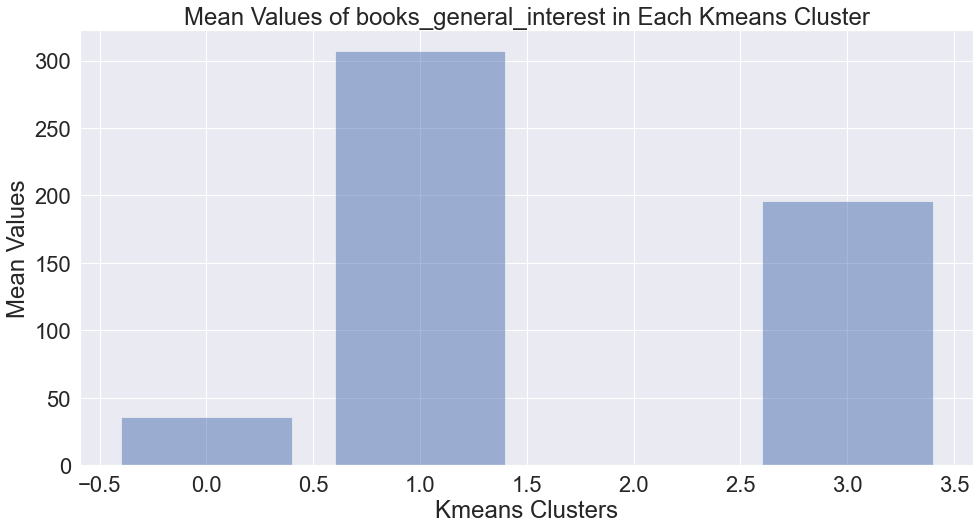

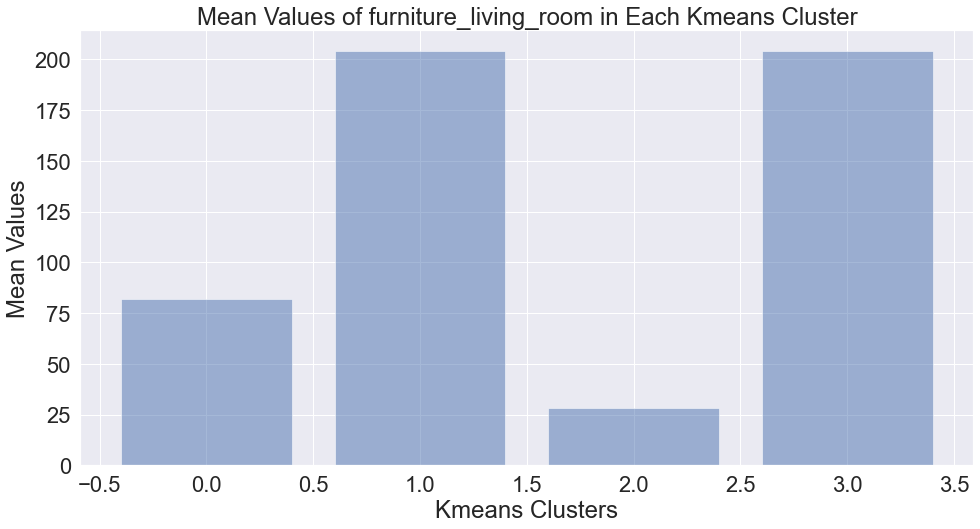

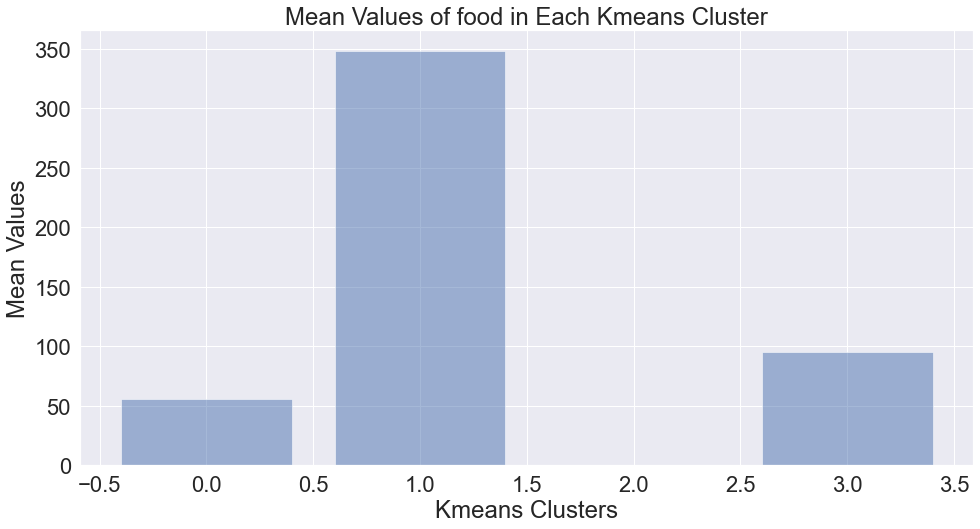

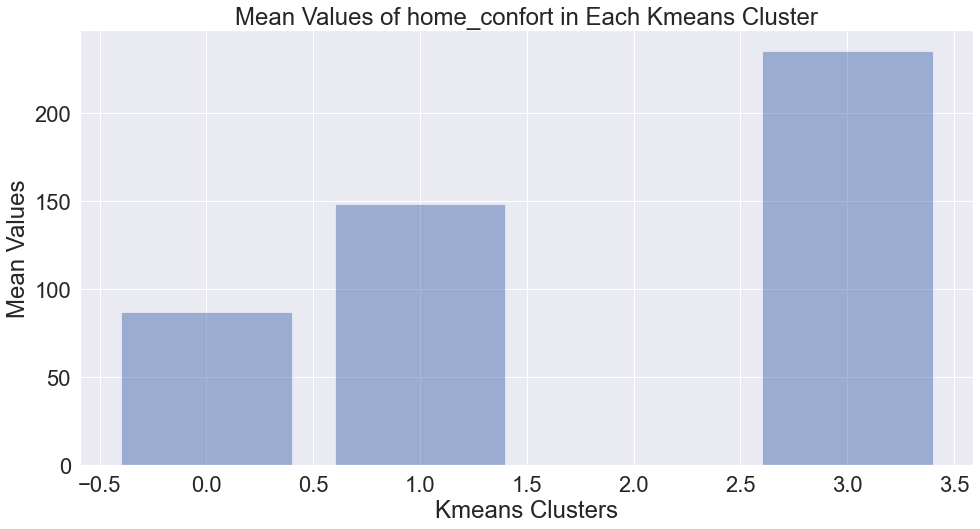

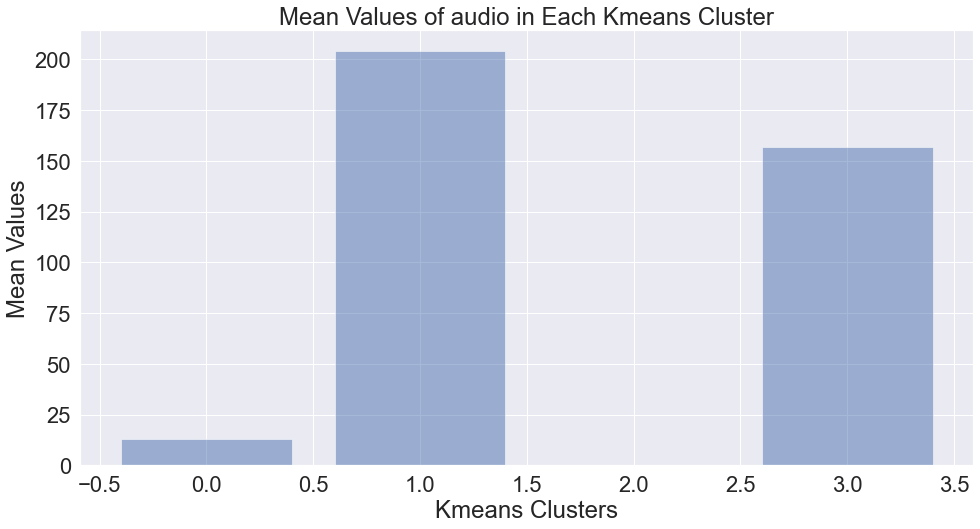

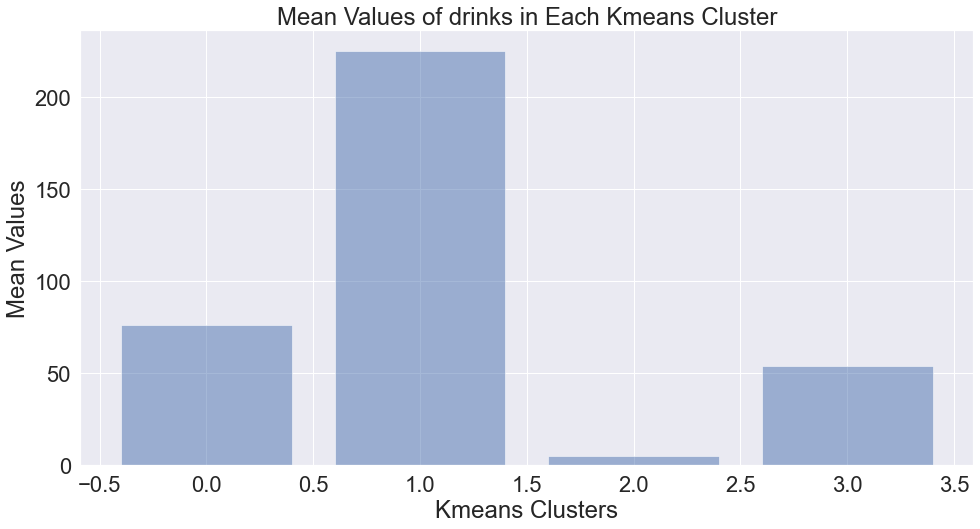

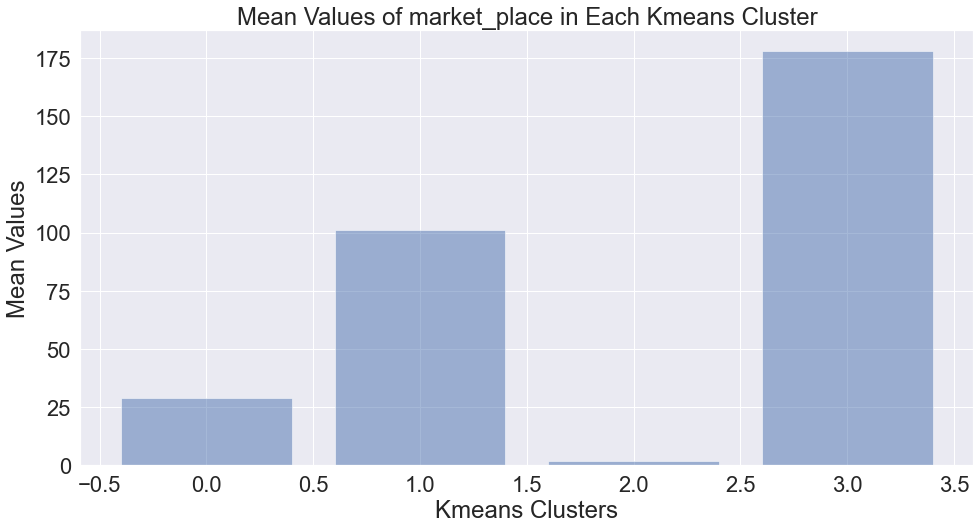

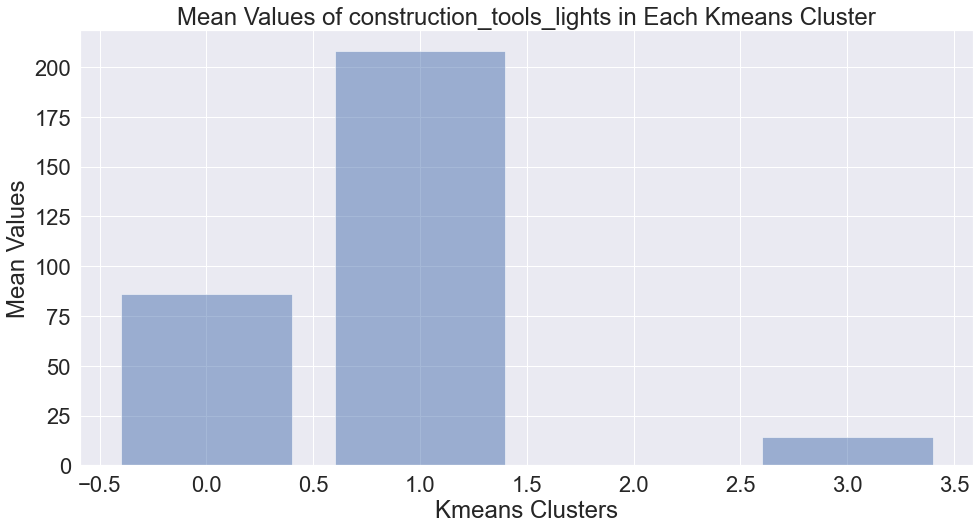

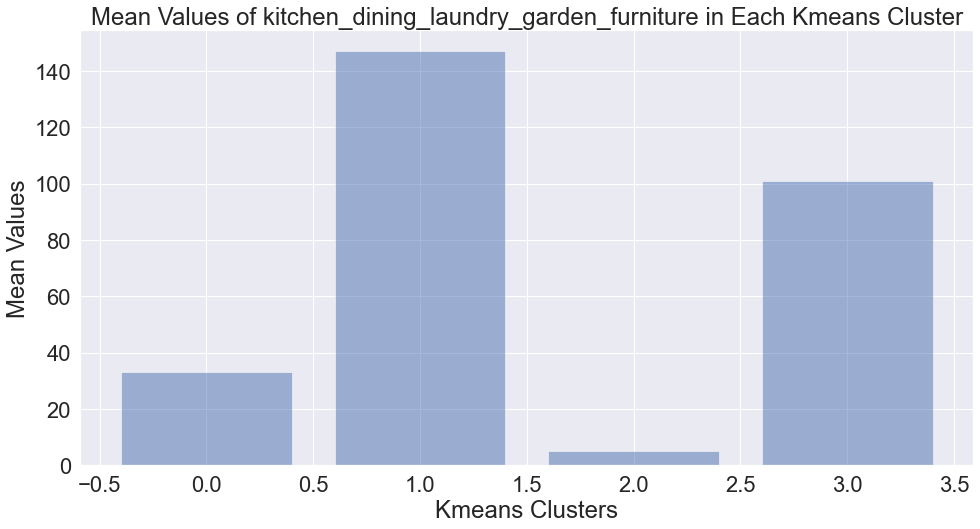

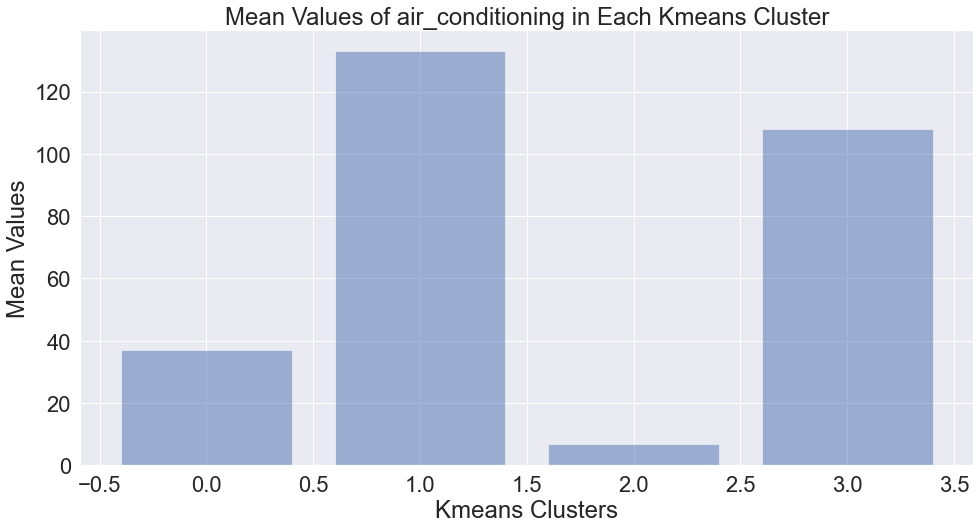

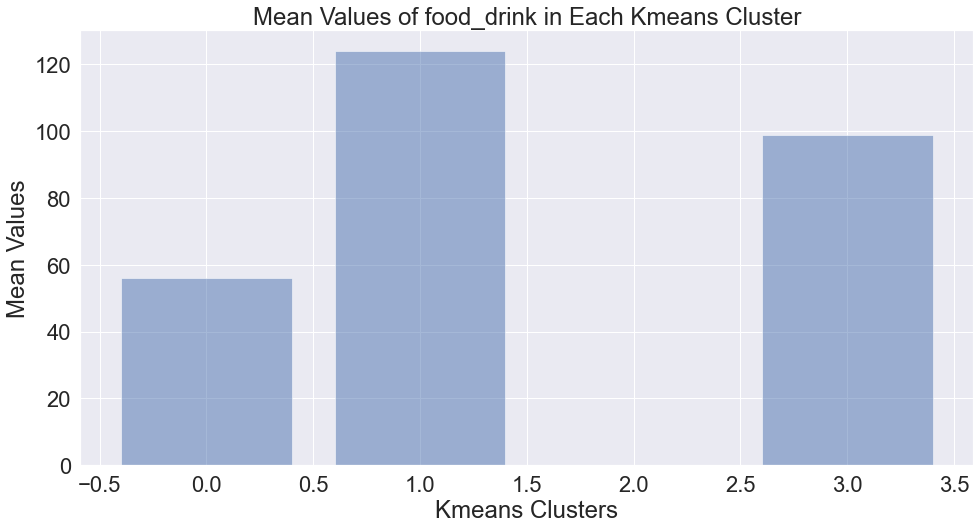

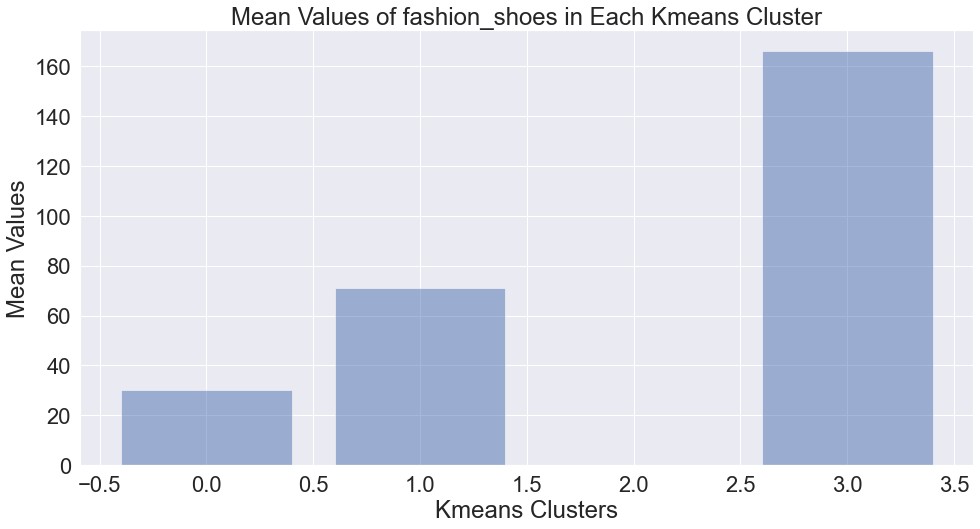

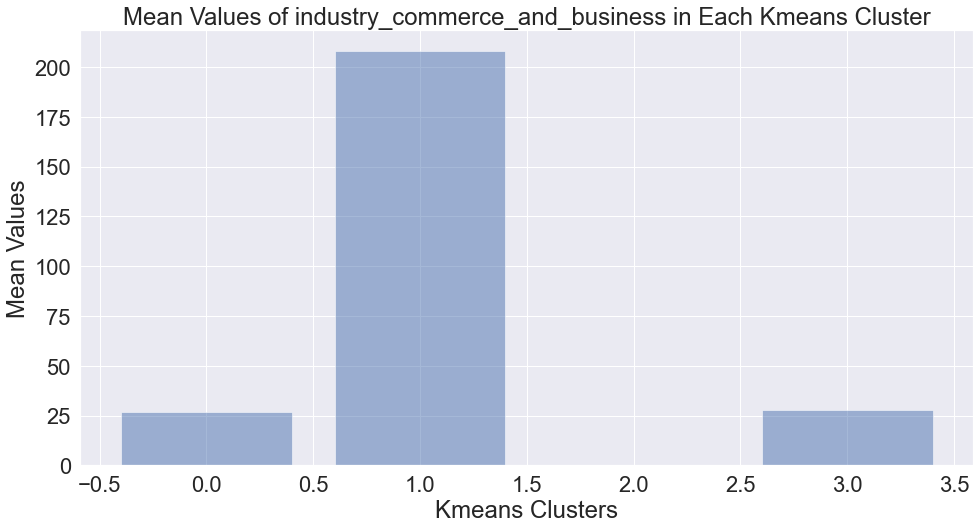

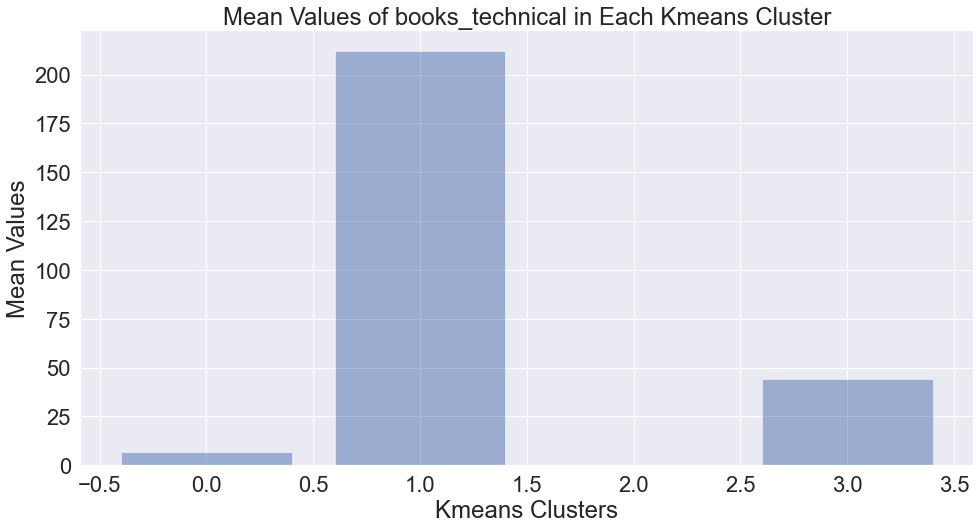

In [88]:
for category in df_categ:
    plt.figure(figsize=[16, 8])
    sns.set(font_scale=2)
    plt.bar(df_categ.index, df_categ[category], alpha=0.5)
    plt.xlabel("Kmeans Clusters")
    plt.ylabel("Mean Values")
    plt.title("Mean Values of " + category + " in Each Kmeans Cluster")
    plt.show()

## Time Analysis

# Analyse en Composante Principale (ACP)